In [1]:
# Real life data

import logging
import threading
import itertools
import json
import os
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func

from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski


from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

#### Train a 2-layered LSTM in Watson Machine Learning

 
Telemanom ([Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://arxiv.org/pdf/1802.04431.pdf) - 2018


Let's find out first what ML libraries are supported by WML.


### Basic Definitions

Forecast 24 data points from a sequence length of 200

In [2]:
#Forecasting
import pyrenn as prn


n_predictions = 24
n_sequence_length = 100

logger = logging

In [3]:
# load data
df_input = pd.read_csv('AllOfArmstark.csv', parse_dates=['timestamp'], comment='#')
#df_input = df_input.asfreq('H')
df_input = df_input.sort_values(by='timestamp').set_index('timestamp')

#df_temp = df_input[['Vx']].shift(1, freq='1D')
df_input['Vx_1'] = df_input[['Vx']].shift(1440)
df_input.dropna(inplace=True)



2021-01-27T12:20:56.015 INFO numexpr.utils._init_num_threads Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-01-27T12:20:56.017 INFO numexpr.utils._init_num_threads NumExpr defaulting to 8 threads.


In [4]:
df_input['on'] = np.where(df_input['As'] > 0.2, 'M', 'F')
df_input['on'] = df_input['on'].astype('category')
df_1 = df_input[df_input['entity'] == '04714B6046D5']
df_2 = df_input[df_input['entity'] == '04714B604101']

df_1.describe()


Vx             Vy             Vz             Ap  \
count  128580.000000  128580.000000  128580.000000  128580.000000   
mean        0.007284      -0.028294      -0.967962       2.453587   
std         0.037609       0.021309       0.049222       0.859291   
min        -0.223600      -0.122100      -1.163100       0.000000   
25%        -0.014600      -0.042000      -1.000000       2.251600   
50%         0.006800      -0.028300      -0.967800       2.313400   
75%         0.030300      -0.014600      -0.935500       2.699600   
max         0.290000       0.075200      -0.753900       5.334001   

                  As          speed           Vx_1  
count  128580.000000  128580.000000  128580.000000  
mean        0.987402       0.987533       0.004984  
std         0.265083       0.264592       0.040814  
min         0.000000       0.000000      -0.337900  
25%         1.036000       1.036000      -0.018600  
50%         1.037000       1.037000       0.005900  
75%         1.063000       1.064136       0.029300  
max         1.197000       1.195605       0.342800

In [5]:
sz = 500
df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)
df_1['max_1'] = sp.ndimage.maximum_filter1d(df_1['Vx_1'], size=sz)
df_2['max_1'] = sp.ndimage.maximum_filter1d(df_2['Vx_1'], size=sz)

<ipython-input-5-e5cbea8455b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['max'] = sp.ndimage.maximum_filter1d(df_1['Vx'], size=sz)
<ipython-input-5-e5cbea8455b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['max'] = sp.ndimage.maximum_filter1d(df_2['Vx'], size=sz)
<ipython-input-5-e5cbea8455b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

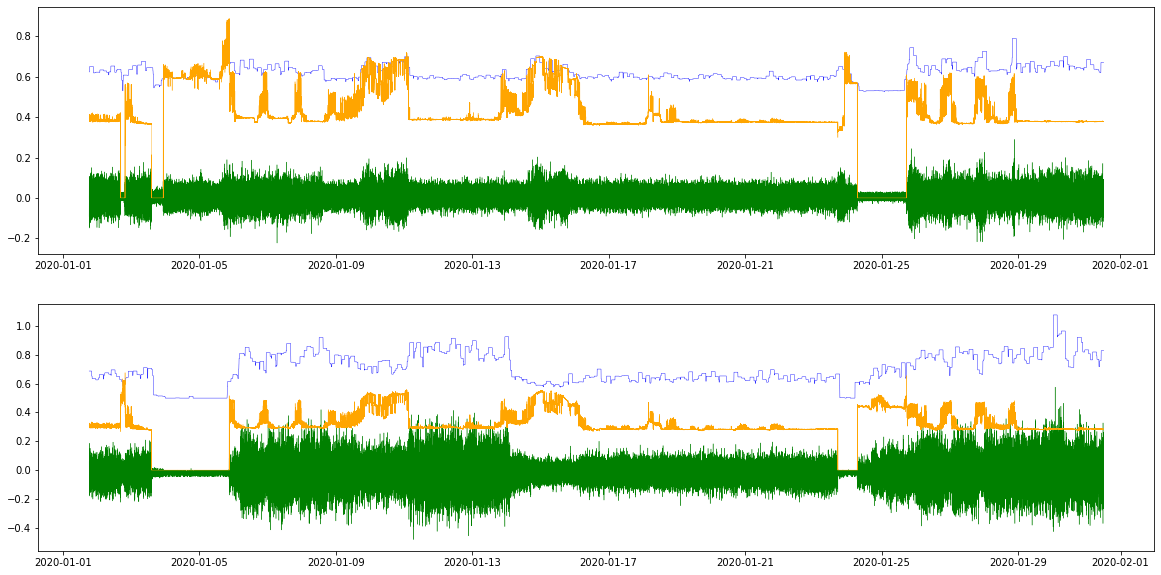

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), squeeze=False)
ax[0,0].plot(df_1['max'] + 0.5, lw=0.4, color='blue', label='max')
ax[0,0].plot(df_1['Vx'], lw=0.4, color='green', label='actual')
ax[0,0].plot(df_1['Ap']/6, lw=0.4, color='orange', label='actual')

ax[1,0].plot(df_2['max'] + 0.5, lw=0.4, color='blue', label='max')
ax[1,0].plot(df_2['Vx'], lw=0.4, color='green', label='actual')
ax[1,0].plot(df_2['Ap']/8, lw=0.4, color='orange', label='actual')



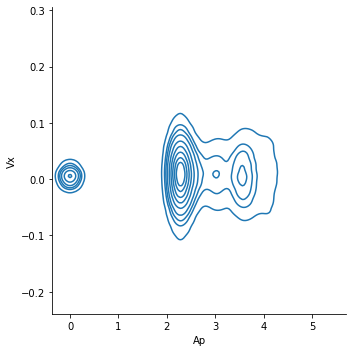

In [7]:
import seaborn as sns

#from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_density import KDEMultivariate

xy1 = np.vstack([df_1['Ap'], df_1['Vx']]).T
xy2 = np.vstack([df_2['Ap'], df_2['Vx']]).T


sns.displot(df_1[['Ap','Vx']], x='Ap', y='Vx', kind="kde")

In [8]:
#from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_density import KDEMultivariate

xy1 = np.vstack([df_1['Ap'], df_1['Vx']]).T
xy2 = np.vstack([df_2['Ap'], df_2['Vx']]).T


#kde1 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xy1)
#kde2 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(xy2)
kde1 = KDEMultivariate(xy1, var_type='cc')
kde2 = KDEMultivariate(xy2, var_type='cc')

#z1 = sp.stats.gaussian_kde(xy1)(xy1)
#z2 = sp.stats.gaussian_kde(xy2)(xy2)

#z1 = kde1.score_samples(xy1)
#z2 = kde2.score_samples(xy2)

z1_orig = kde1.pdf(xy1)
z2_orig = kde1.pdf(xy2)

In [9]:
#zc1 = kde1.cdf(xy1)
#zc2 = kde2.cdf(xy1)

In [10]:
idx1 = z1_orig.argsort()
idx2 = z2_orig.argsort()
x1, y1, z1 = df_1['Ap'][idx1], df_1['Vx'][idx1], z1_orig[idx1]
x2, y2, z2 = df_2['Ap'][idx2], df_2['Vx'][idx2], z2_orig[idx2]



In [11]:
xy1[idx1], z1[0:10]

(array([[ 3.637 ,  0.29  ],
        [ 1.283 , -0.1211],
        [ 5.2356, -0.1318],
        ...,
        [ 2.2868,  0.0088],
        [ 2.2856,  0.0088],
        [ 2.286 ,  0.0088]]),
 array([0.00172056, 0.00172056, 0.0017208 , 0.00172111, 0.00172333,
        0.00172341, 0.00172639, 0.00172659, 0.0017267 , 0.00172775]))

In [12]:
xy2[idx2], z2[0:10]

(array([[ 2.2958,  0.5752],
        [ 2.3398, -0.4814],
        [ 2.3272, -0.4561],
        ...,
        [ 2.2854,  0.0088],
        [ 2.2856,  0.0088],
        [ 2.2862,  0.0088]]),
 array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 2.55463815e-288,
        1.11006078e-282, 3.01720139e-256, 3.82423024e-256, 4.92284528e-236,
        1.09410075e-228, 3.40341939e-226]))

In [13]:
grid = np.mgrid[0:5.5:0.02, -0.6:0.6:0.01].reshape(2,-1).T
grid.shape
zfull1 = kde1.pdf(grid)
zfull2 = kde2.pdf(grid)


                        

In [14]:
xf1 = grid.T[0]
yf1 = grid.T[1]
xf2 = grid.T[0]
yf2 = grid.T[1]

yf1[zfull1 < 0.00001] = np.nan
yf2[zfull2 < 0.00001] = np.nan

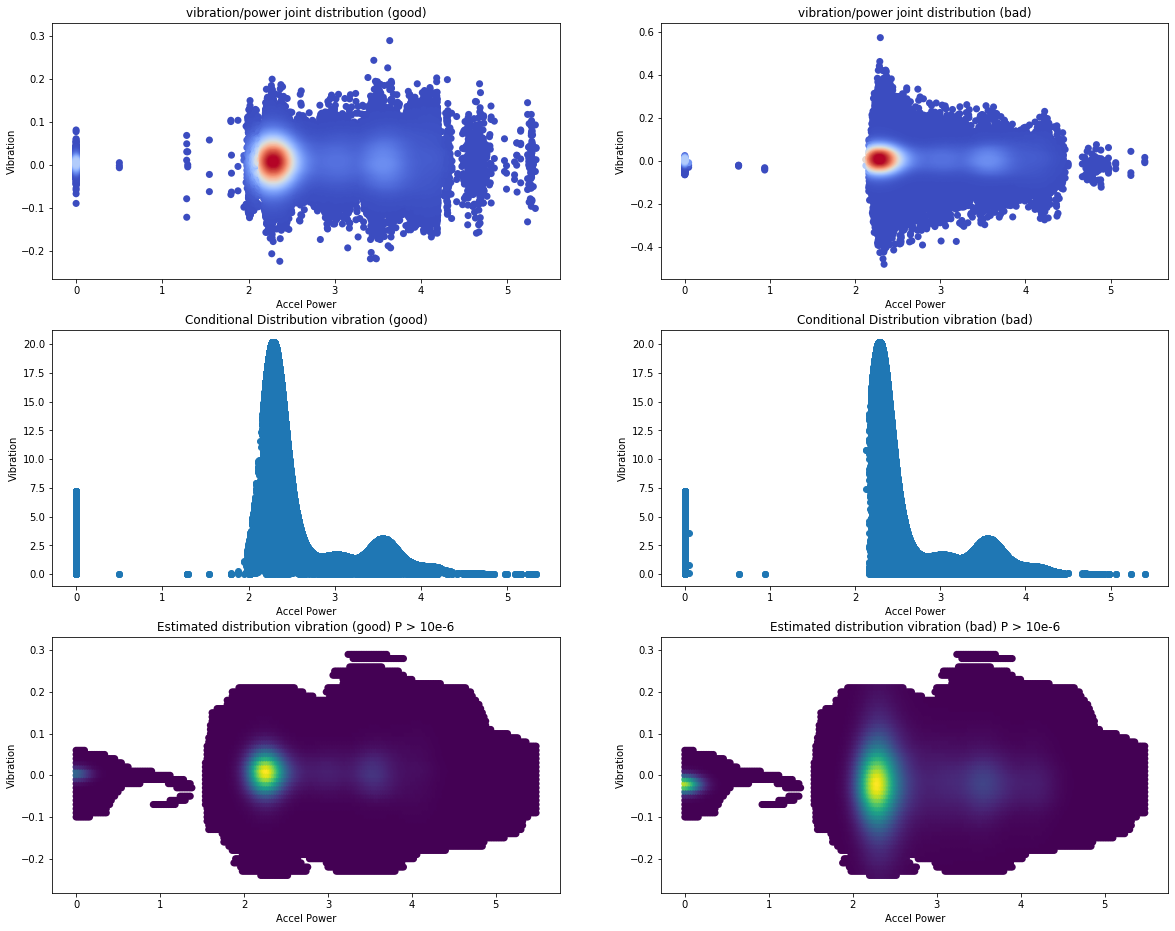

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(3, 2, figsize=(20, 16), squeeze=False)
#ax[0,0].scatter(df_1['Ap'], df_1['Vx'], color='green', lw=0.4)

ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
ax[0,0].set_title('vibration/power joint distribution (good)')


#ax[0,1].contour(x1, y1, z1, levels=z1_a, colors='red', linewidths=1)
#ax[1,0].scatter(df_2['Ap'], df_2['Vx'], color='green', lw=0.4)

ax[0,1].scatter(x2, y2, c=z2, s=50, edgecolor='', cmap='coolwarm')
ax[0,1].set_title('vibration/power joint distribution (bad)')


ax[1,0].scatter(x1, z1)
ax[1,0].set_title('Conditional Distribution vibration (good)')
ax[1,1].scatter(x2, z2)
ax[1,1].set_title('Conditional Distribution vibration (bad)')


ax[2,0].scatter(xf1, yf1, c=zfull1, s=50, edgecolor='', cmap='viridis')
ax[2,0].set_title('Estimated distribution vibration (good) P > 10e-6')
ax[2,1].scatter(xf2, yf2, c=zfull2, s=50, edgecolor='', cmap='viridis')
ax[2,1].set_title('Estimated distribution vibration (bad) P > 10e-6')
#ax[2,1].set_title('vibration/power \"cross entropy\" (bad)')

for i in (0,1,2):
    for j in (0,1):
        ax[i,j].set_xlabel('Accel Power')
        ax[i,j].set_ylabel('Vibration')




### Try to render the probability density function as combination of Gaussians

In [16]:
# sort 
nn = 90000
idx11 = np.argsort(-1 * z1)[1:nn]

print (xy1[idx11].shape, xy1.shape)

nr_comp=3


from sklearn.mixture import BayesianGaussianMixture
BGM = BayesianGaussianMixture(n_components=nr_comp, verbose=1, n_init=4,
                              init_params='random', weight_concentration_prior_type='dirichlet_distribution',
                              covariance_type='full')
#BGM.mean_prior = [[2.3, 3.5, 0], [0,0,0]]
BGM.fit(xy1)

(89999, 2) (128580, 2)
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


BayesianGaussianMixture(init_params='random', n_components=3, n_init=4,
                        verbose=1,
                        weight_concentration_prior_type='dirichlet_distribution')

In [17]:
Y = BGM.predict_proba(xy1) #[idx11])

In [18]:
BGM.mean_prior_

array([2.45358737, 0.00728384])

#### Not exactly what I want

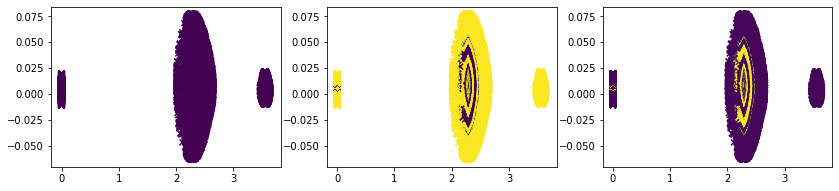

In [19]:
plt.figure(figsize=(14,10))
for i in range(nr_comp):
    plt.subplot(nr_comp,nr_comp,i+1)
    #plt.scatter(x1[idx11],y1[idx11],c=BGM.predict_proba(xy1[idx11])[:,i],cmap='viridis',marker='x')
    plt.scatter(x1[idx11],y1[idx11],c=BGM.predict_proba(xy1)[:nn-1,i],cmap='viridis',marker='x')



### Variational Inference with a neural network

Try to approximate the actual probability density a Gaussian whose parameters depend on $x$

$Q = \mathcal{N}(g(x), h(x))$

with g,h in the function space of 

$max(0, max(0, x A_0^\top + b_0) \cdot A_1^\top + b_1) \cdot A_2^\top + b_2$.

$A_0 \in \mathbb{R}^1 \times \mathbb{R}^{20}$

$A_1 \in \mathbb{R}^{20} \times \mathbb{R}^{10}$

$A_2 \in \mathbb{R}^{10} \times \mathbb{R}^1$



In [20]:
import torch
import torch.autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.dataset import random_split

In [21]:
# sort data by x-axis
ind = np.lexsort((xy1[:,1], xy1[:,0]))

# turn it into tensors
# xy1 = np.vstack([df_1['Ap'], df_1['Vx']]).T
X = torch.tensor(xy1[ind][:,0].reshape(-1,1), dtype=torch.float)
Y = torch.tensor(xy1[ind][:,1].reshape(-1,1), dtype=torch.float)


#### Log likelihood Gaussian helper function

$ -\frac{n}{2}(2\pi \sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^n(x_i - \mu)^2 $

In [22]:
# helper function
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

#### ELBO loss function

$L(\mu,\sigma) =  E_{\mu,\sigma}[ \log( P(y | \mu, \sigma )] + \int_\theta q_{\mu,\sigma}(\theta)  \left( log p_{prior}(\theta) -
log q_{\mu,\sigma}(\theta) \right) $

    `log Likelihood of observations  + log prior of predictions - log variational probability of prediction`

__Reconstruction loss__: likelihood of the observed target variable y in terms of $\mathcal{N}(\mu, \sigma)$

$E_{\mu,\sigma}[ \log( P(y | \mu, \sigma )]$ 

__KL-divergence__ of the unparametrized Prior $\mathcal{N}(0, 1)$ against Q = $\mathcal{N}(\mu, \sigma)$ with respect to the predicted variable

__Cheat__: Mean instead of integral for the expected value - aka law of large numbers

__Simplify__: Compute KL divergence between prior and variational probability analytically with
$KL(q, p) = \log \frac{\sigma_1}{\sigma_2} + \frac{\sigma_2^2 + (\mu_2 - \mu_1)^2}{2 \sigma_1^2} - \frac{1}{2}$

In [54]:
# from https://www.ritchievink.com/blog/2019/09/16/variational-inference-from-scratch/
#   ELBO with standard prior N(0,1)

class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 50),    # more parameters for sigma
            nn.ReLU(),
            nn.Linear(50, 35),
            nn.ReLU(),
            nn.Linear(35, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )
        self.beta = 1.0
        self.prior_mu = 0.0
        self.prior_sigma = 1.0

    # draw from N(mu, sigma)
    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        return mu + sigma * eps

    # sample from the one-dimensional normal distribution N(mu, exp(log_var))
    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var
    
    def elbo(self, y_pred, y, mu, log_var):
        # likelihood of observing y given Variational mu and sigma
        likelihood = ll_gaussian(y, mu, log_var)
    
        # prior probability of y_pred N(0,1)
        log_prior = ll_gaussian(y_pred, self.prior_mu, torch.log(torch.tensor(self.prior_sigma)))
    
        # variational probability of y_pred
        log_p_q = ll_gaussian(y_pred, mu, log_var)
        
        # by taking the mean we approximate the expectation according to the law of large numbers
        #   it would be more logical to analytically compute the KL divergence between prior and p_q
        #    as we compute the Gaussian parameters anyway before we draw y_pred from them
        #converge = torch.var(likelihood + self.beta * (log_prior - log_p_q))
        
        #sigma2 = torch.tensor(self.prior_sigma)
        #mu2 = torch.tensor(self.prior_mu)
                
        #return likelihood.mean() + (log_var - torch.log(sigma2) + (sigma2**2 + (mu2 - mu)**2) / torch.exp(log_var)**2).mean()
        
        return (likelihood + self.beta * (log_prior - log_p_q)).mean()

    # Minimizing negative ELBO
    def det_loss(self, y_pred, y, mu, log_var):
        return -elbo(y_pred, y, mu, log_var)

#### ELBO

__Reconstruction loss__: likelihood of the observed target variable y in terms of $\mathcal{N}(\mu, \sigma)$

$E_{\mu,\sigma}[ \log( P(y | \mu, \sigma )]$ 

__KL-divergence__ of the unparametrized Prior $\mathcal{N}(0, 1)$ against Q = $\mathcal{N}(\mu, \sigma)$ with respect to the predicted variable

__Cheat__: Mean instead of integral for the expected value

In [55]:
#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter('./runs/miniVAE')

In [56]:
# probability of max/min vibration with regard to prior mu,sigma
#sp.stats.norm.pdf(0.3, 0.0, 2.0)

In [57]:
epochs = 1000 #1500
learning_rate = 0.05

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=learning_rate)

m.beta = 1.0
m.prior_mu = 0.0
m.prior_sigma = 2.0 # 

#running_loss = 0.0
for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    #C = torch.clamp(C_max/self.C_stop_iter * epoch, 0, self.C_max.data[0])
    loss = - m.elbo(y_pred, Y, mu, log_var)
    running_loss = loss.item()
    #writer.add_scalar('training loss', running_loss, epoch)
    if epoch % 10 == 0:
        print ('Epoch', epoch, 'Loss', loss.item())
    loss.backward()
    grad_norm = 0
    #for p in m.parameters():
    #    with torch.no_grad():
    #        grad_norm += torch.sum(p.grad.data**2)
    #print("Norm of gradient:", grad_norm)
    #if grad_norm < 1e-5: break
    optim.step()

Epoch 0 Loss 1.0546958446502686
Epoch 10 Loss 0.8677608966827393
Epoch 20 Loss 0.8155898451805115
Epoch 30 Loss 0.7968869209289551
Epoch 40 Loss 0.7927137017250061
Epoch 50 Loss 0.7948107123374939
Epoch 60 Loss 0.7901800870895386
Epoch 70 Loss 0.7920463681221008
Epoch 80 Loss 0.7876989245414734
Epoch 90 Loss 0.7908912301063538
Epoch 100 Loss 0.7893772721290588
Epoch 110 Loss 0.7918234467506409
Epoch 120 Loss 0.7905218005180359
Epoch 130 Loss 0.7940202951431274
Epoch 140 Loss 0.7900410890579224
Epoch 150 Loss 0.7926357984542847
Epoch 160 Loss 0.7892275452613831
Epoch 170 Loss 0.7934120297431946
Epoch 180 Loss 0.7919626832008362
Epoch 190 Loss 0.7902942299842834
Epoch 200 Loss 0.790865957736969
Epoch 210 Loss 0.7925677299499512
Epoch 220 Loss 0.7911145091056824
Epoch 230 Loss 0.7931188941001892
Epoch 240 Loss 0.791709303855896
Epoch 250 Loss 0.7917938232421875
Epoch 260 Loss 0.791631281375885
Epoch 270 Loss 0.7893954515457153
Epoch 280 Loss 0.7907439470291138
Epoch 290 Loss 0.78991729021

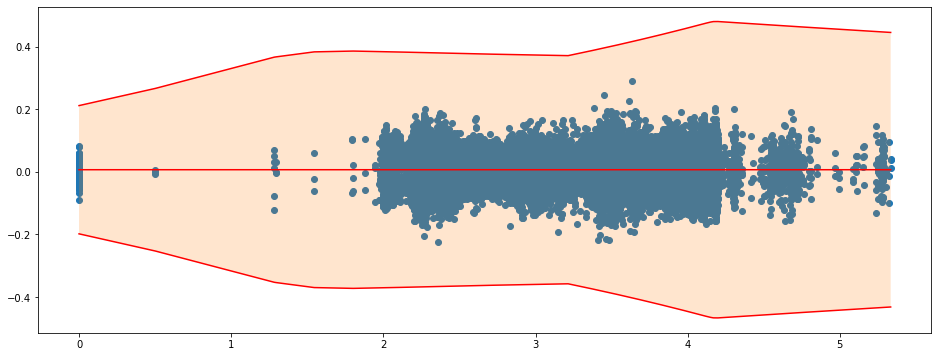

In [253]:
mu = None
q1 = None
q2 = None
with torch.no_grad():
    mu_and_log_sigma = m(X)
    mue = mu_and_log_sigma[1]
    sigma = torch.exp(0.5 * mu_and_log_sigma[2]) + 1e-5
    q1 = sp.stats.norm.ppf(0.05, loc=mue, scale=sigma).reshape(-1,)
    mu = sp.stats.norm.ppf(0.5, loc=mue, scale=sigma).reshape(-1,)
    q2 = sp.stats.norm.ppf(0.95, loc=mue, scale=sigma).reshape(-1,)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu, color='red')
plt.plot(X, q1, color='red')
plt.plot(X, q2, color='red')


plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

In [178]:
'''
# draw samples from Q(theta)
with torch.no_grad():
    # collect first tensor with the results from forward() a couple (1000) of times
    # second and third tensors m(X)[1/2] deliver mean and log variance
    #  I guess we could directly compute the quantiles from it
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2)

print (q1.shape, mu.shape, q2.shape)
'''

'\n# draw samples from Q(theta)\nwith torch.no_grad():\n    # collect first tensor with the results from forward() a couple (1000) of times\n    # second and third tensors m(X)[1/2] deliver mean and log variance\n    #  I guess we could directly compute the quantiles from it\n    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)\n    \n# Get some quantiles\nq1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)\n\nplt.figure(figsize=(16, 6))\nplt.scatter(X, Y)\nplt.plot(X, mu)\nplt.fill_between(X.flatten(), q1, q2, alpha=0.2)\n\nprint (q1.shape, mu.shape, q2.shape)\n'

In [255]:
# same for bad pump, xy2
ind2 = np.lexsort((xy2[:,1], xy2[:,0]))
X2 = torch.tensor(xy2[ind2][:,0].reshape(-1,1), dtype=torch.float)
Y2 = torch.tensor(xy2[ind2][:,1].reshape(-1,1), dtype=torch.float)

epochs = 1500

m2 = VI()

m2.beta = 1.0
m2.prior_mu = 0.0
m2.prior_sigma = 2.0  #  N(0,2)


optim2 = torch.optim.Adam(m2.parameters(), lr=0.005)

for epoch in range(epochs):
    optim2.zero_grad()
    y_pred, mu, log_var = m2(X)
    if epoch % 10 == 0:
        print ('Epoch', epoch, 'Loss', loss.item())
    loss = -elbo(y_pred, Y, mu, log_var)
    loss.backward()
    optim2.step()

Epoch 0 Loss 0.7907910943031311
Epoch 10 Loss 0.22518540918827057
Epoch 20 Loss 0.166386216878891
Epoch 30 Loss 0.15480467677116394
Epoch 40 Loss 0.13558271527290344
Epoch 50 Loss 0.13314376771450043
Epoch 60 Loss 0.13372692465782166
Epoch 70 Loss 0.12675555050373077
Epoch 80 Loss 0.12319456785917282
Epoch 90 Loss 0.12753692269325256
Epoch 100 Loss 0.12750880420207977
Epoch 110 Loss 0.12480545789003372
Epoch 120 Loss 0.12411834299564362
Epoch 130 Loss 0.12666332721710205
Epoch 140 Loss 0.12107011675834656
Epoch 150 Loss 0.12320322543382645
Epoch 160 Loss 0.12426596134901047
Epoch 170 Loss 0.1231655701994896
Epoch 180 Loss 0.12085963040590286
Epoch 190 Loss 0.12464620918035507
Epoch 200 Loss 0.1240556389093399
Epoch 210 Loss 0.12416129559278488
Epoch 220 Loss 0.12382429093122482
Epoch 230 Loss 0.12637239694595337
Epoch 240 Loss 0.12419143319129944
Epoch 250 Loss 0.12614455819129944
Epoch 260 Loss 0.12249220162630081
Epoch 270 Loss 0.12605446577072144
Epoch 280 Loss 0.12317804247140884
E

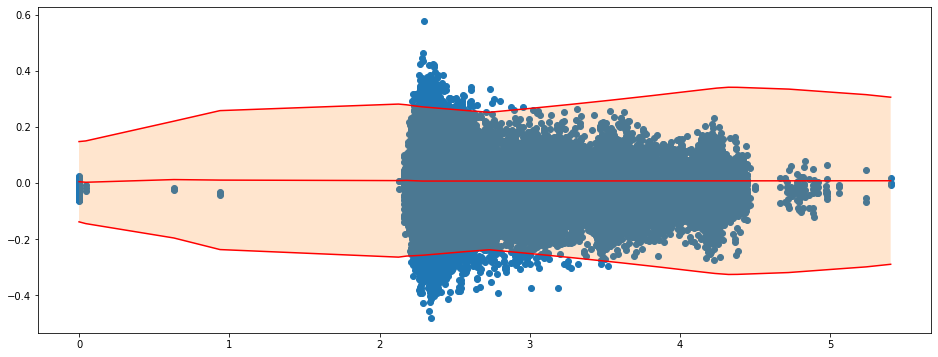

In [256]:
dmu = None
q1 = None
q2 = None
with torch.no_grad():
    mu_and_log_sigma = m2(X2)
    mue = mu_and_log_sigma[1]
    sigma = torch.exp(0.5 * mu_and_log_sigma[2]) + 1e-5
    q1 = sp.stats.norm.ppf(0.05, loc=mue, scale=sigma).reshape(-1,)
    mu = sp.stats.norm.ppf(0.5, loc=mue, scale=sigma).reshape(-1,)
    q2 = sp.stats.norm.ppf(0.95, loc=mue, scale=sigma).reshape(-1,)

plt.figure(figsize=(16, 6))
plt.scatter(X2, Y2)
plt.plot(X2, mu, color='red')
plt.plot(X2, q1, color='red')
plt.plot(X2, q2, color='red')


plt.fill_between(X2.flatten(), q1, q2, alpha=0.2)

In [22]:
import pymc3 as pm
import theano.tensor as tt



In [23]:
#background https://luiarthur.github.io/statorial/varinf/introvi/
# from https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html
%env THEANO_FLAGS=device=cpu,floatX=float32

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, DensityDist, find_MAP, NUTS, Slice
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

print('Running on PyMC3 v{}'.format(pm.__version__))

env: THEANO_FLAGS=device=cpu,floatX=float32
Running on PyMC3 v3.9.3


In [24]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [25]:
xy1.shape

(128580, 2)

In [27]:
from pymc3.math import logsumexp

n_samples = xy1.shape[0]

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution - q
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

with pm.Model() as model:
    #mus = [MvNormal('mu_%d' % i,
    #                mu=pm.floatX(np.zeros(2)),
    #                tau=pm.floatX(0.1 * np.eye(2)),
    #                shape=(2,))
    #       for i in range(2)]
    # 3 gaussian priors
    mu_0 = MvNormal('mu_0', mu=pm.floatX(np.array([0,0])), tau= pm.floatX(0.1 * np.eye(2)), shape=(2,))
    mu_1 = MvNormal('mu_1', mu=pm.floatX(np.array([2.3,0])), tau= pm.floatX(0.1 * np.eye(2)), shape=(2,))
    mu_2 = MvNormal('mu_2', mu=pm.floatX(np.array([3.5,0])), tau= pm.floatX(0.1 * np.eye(2)), shape=(2,))
    mu_3 = MvNormal('mu_3', mu=pm.floatX(np.array([5.1,0])), tau= pm.floatX(0.1 * np.eye(2)), shape=(2,))
    mu_4 = MvNormal('mu_4', mu=pm.floatX(np.array([0,0])), tau= pm.floatX(0.1 * np.eye(2)), shape=(2,))
    mu_5 = MvNormal('mu_5', mu=pm.floatX(np.array([0,0])), tau= pm.floatX(0.1 * np.eye(2)), shape=(2,))

    mus = [mu_0, mu_1, mu_2, mu_3, mu_4, mu_5]
    
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(len(mus))), shape=(len(mus),))
    
    # likelihood
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=xy1)
    
    # NUTS sampler takes ages ...
    #trace = pm.sample(draws=2000, chains=8)

In [28]:
model.check_test_point()

mu_0                      -4.14
mu_1                      -4.14
mu_2                      -4.14
mu_3                      -4.14
mu_4                      -4.14
mu_5                      -4.14
pi_stickbreaking__       -14.19
x                    -391554.66
Name: Log-probability of test_point, dtype: float64

In [29]:
mus[0]

mu_0

In [30]:
with model:
    #empiric = pm.Empirical(trace)
    trace = pm.sample(draws=2000, chains=3)

2020-11-20T19:53:59.053 INFO pymc3.sample Auto-assigning NUTS sampler...
2020-11-20T19:53:59.053 INFO pymc3.init_nuts Initializing NUTS using jitter+adapt_diag...
2020-11-20T19:54:06.471 INFO pymc3.sample Multiprocess sampling (3 chains in 4 jobs)
2020-11-20T19:54:06.476 INFO pymc3._print_step_hierarchy NUTS: [pi, mu_5, mu_4, mu_3, mu_2, mu_1, mu_0]


ValueError: Not enough samples to build a trace.

2020-11-20T20:18:05.866 INFO pymc3.variational.inference._iterate_with_loss Finished [100%]: Average Loss = 2.8382e+05


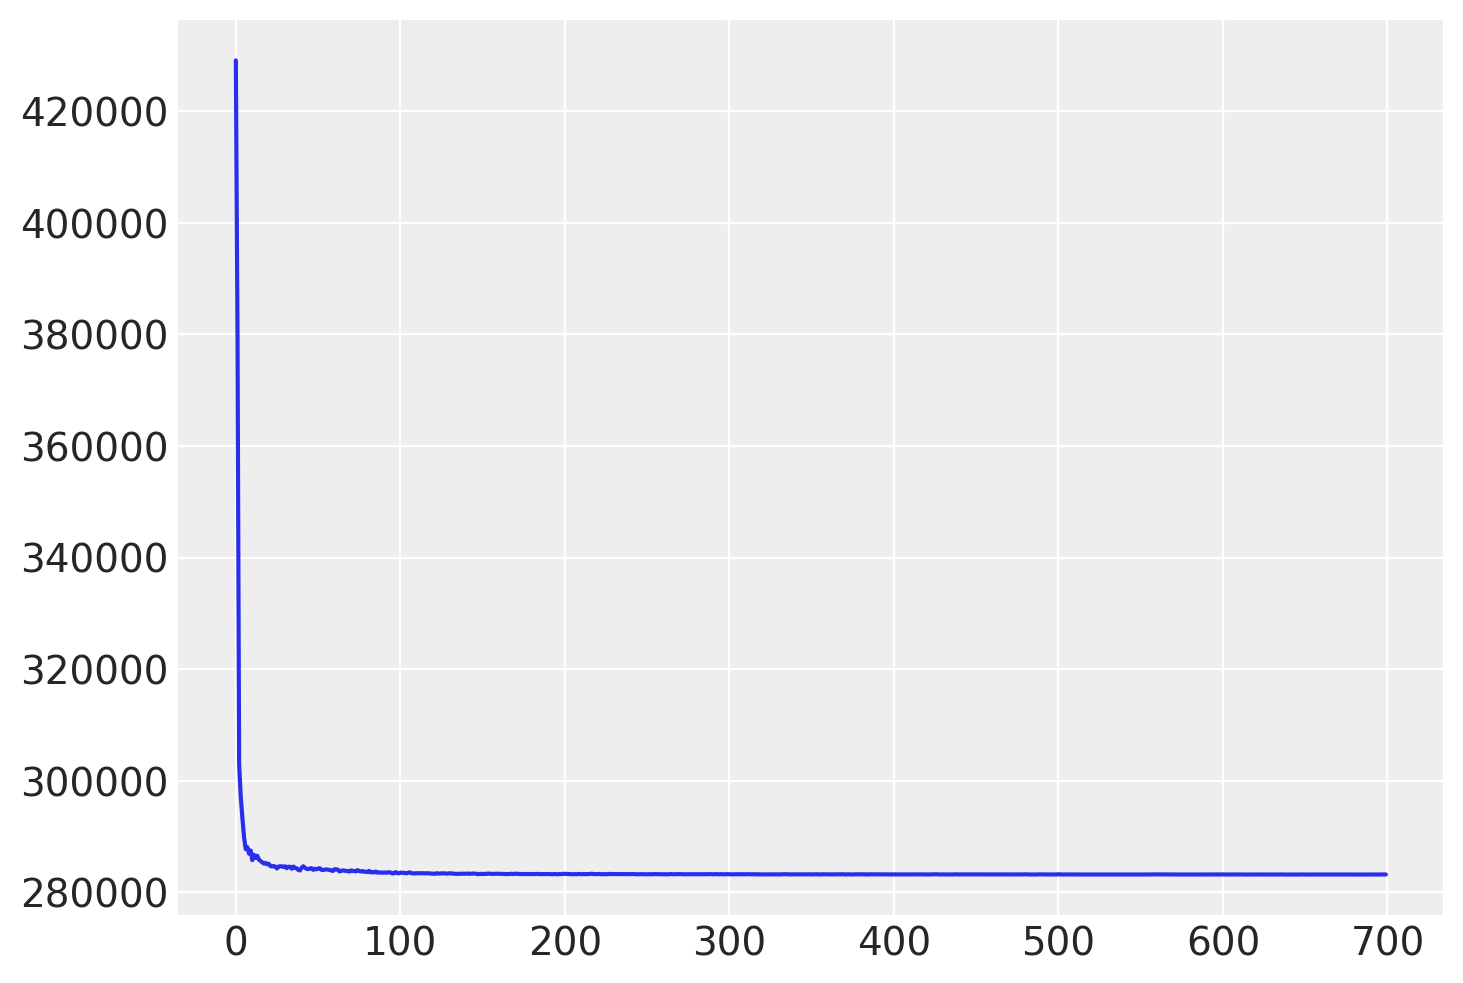

In [31]:

with model:
    approx = pm.fit(method='advi',
                    n=700,
                    obj_n_mc=10,
                    callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute',tolerance=2e-4)],
                    obj_optimizer=pm.adagrad(learning_rate=1.))
    plt.plot(approx.hist)

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

In [32]:
   
with pm.Model() as model2:
    component0 = pm.MvNormal('c0', mu=[0, 0], tau= pm.floatX(0.1 * np.eye(2)), shape=(2,))
    component1 = pm.MvNormal('c1', mu=[0, 0], tau= pm.floatX(0.1 * np.eye(2)), shape=(2,))
    w = pm.Beta('w', 1, 1)
    mix = pm.Mixture('mix', w=[w, 1 - w], comp_dists=[component0.distribution, component1.distribution], shape=2)
    obs = pm.Normal('obs', mu=mix[0] + mix[1], sigma= 1, observed=xy1)


In [33]:
with model2:
    #empiric = pm.Empirical(trace)
    trace = pm.sample(draws=1000, chains=3)

2020-11-20T20:18:07.834 INFO pymc3.sample Auto-assigning NUTS sampler...
2020-11-20T20:18:07.835 INFO pymc3.init_nuts Initializing NUTS using jitter+adapt_diag...
2020-11-20T20:18:09.614 INFO pymc3.sample Multiprocess sampling (3 chains in 4 jobs)
2020-11-20T20:18:09.614 INFO pymc3._print_step_hierarchy NUTS: [mix, w, c1, c0]


2020-11-20T21:02:57.532 INFO pymc3.sample Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 2688 seconds.
2020-11-20T21:03:04.759 WARNING pymc3.log_warning The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
2020-11-20T21:03:04.761 ERROR pymc3.log_warning There were 996 divergences after tuning. Increase `target_accept` or reparameterize.
2020-11-20T21:03:04.761 WARNING pymc3.log_warning The acceptance probability does not match the target. It is 0.5871712139994492, but should be close to 0.8. Try to increase the number of tuning steps.
2020-11-20T21:03:04.762 WARNING pymc3.log_warning The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
2020-11-20T21:03:04.762 ERROR pymc3.log_warning The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
2020-11-20T21:03:04.763 ERROR pymc3.log_warning The estimated nu

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


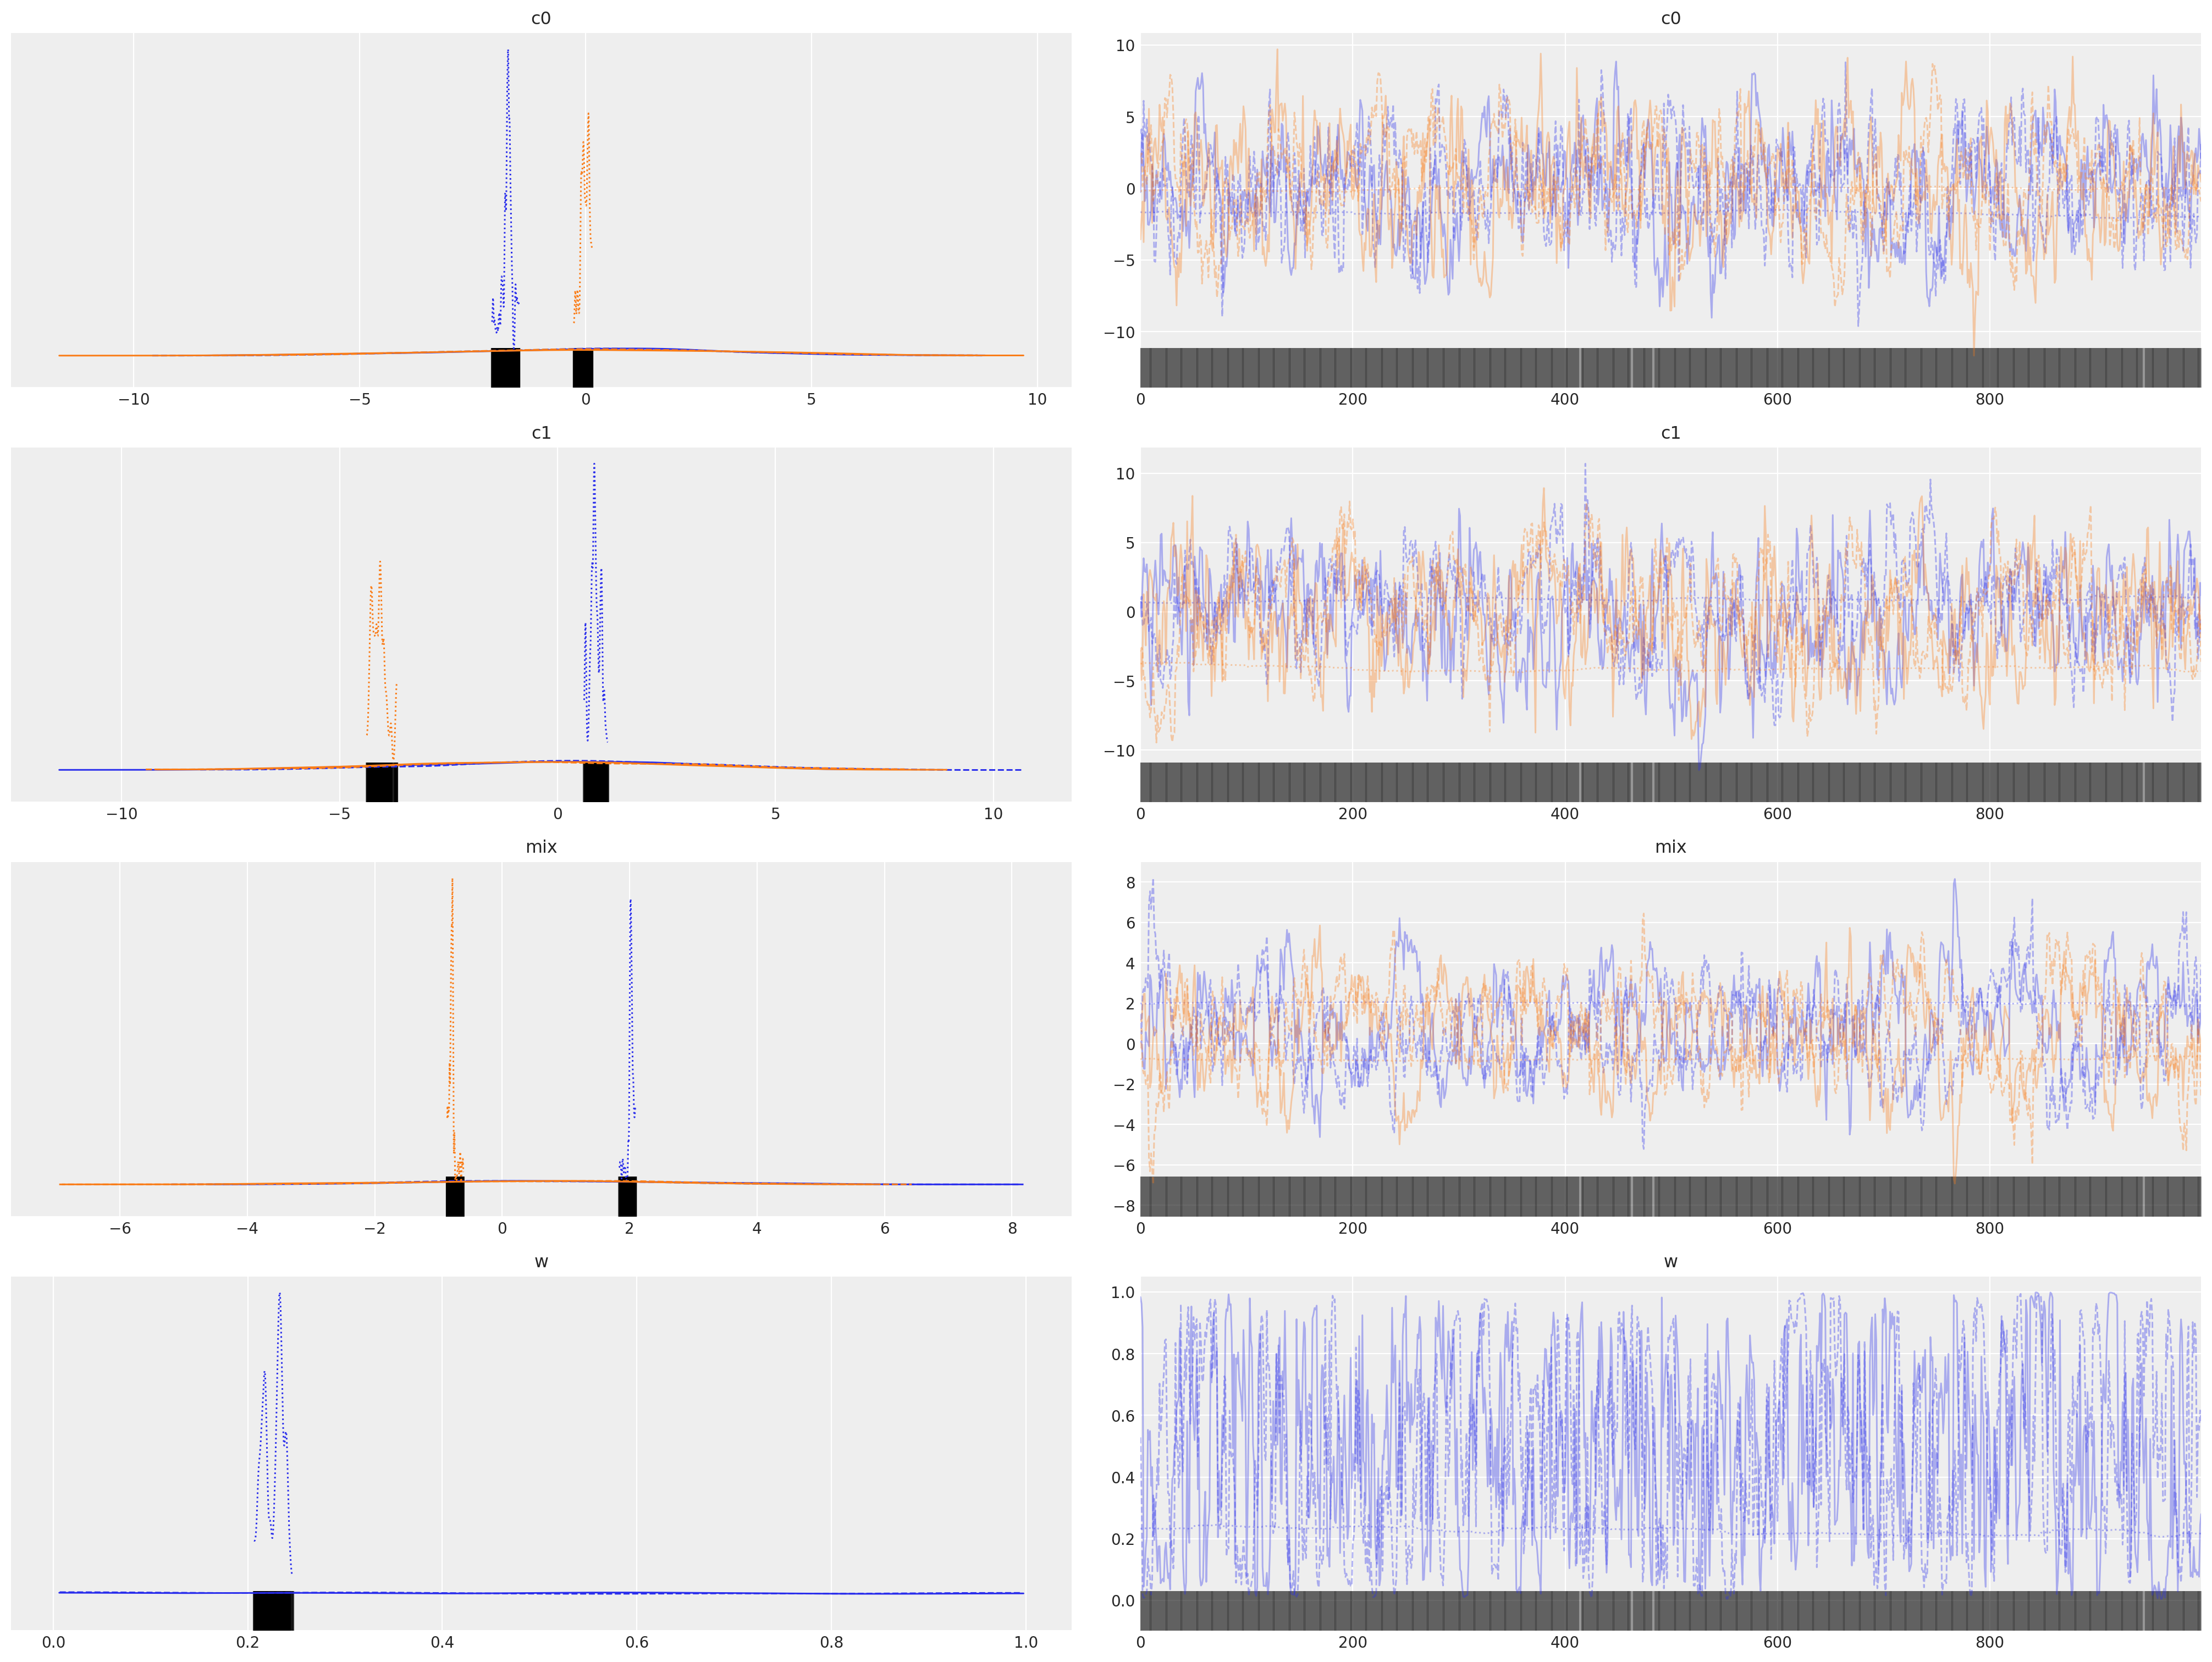

In [36]:
pm.traceplot(trace,figsize=(20,15));

2020-11-20T16:34:27.679 INFO pymc3.variational.inference._iterate_with_loss Finished [100%]: Average Loss = 4.9024e+05


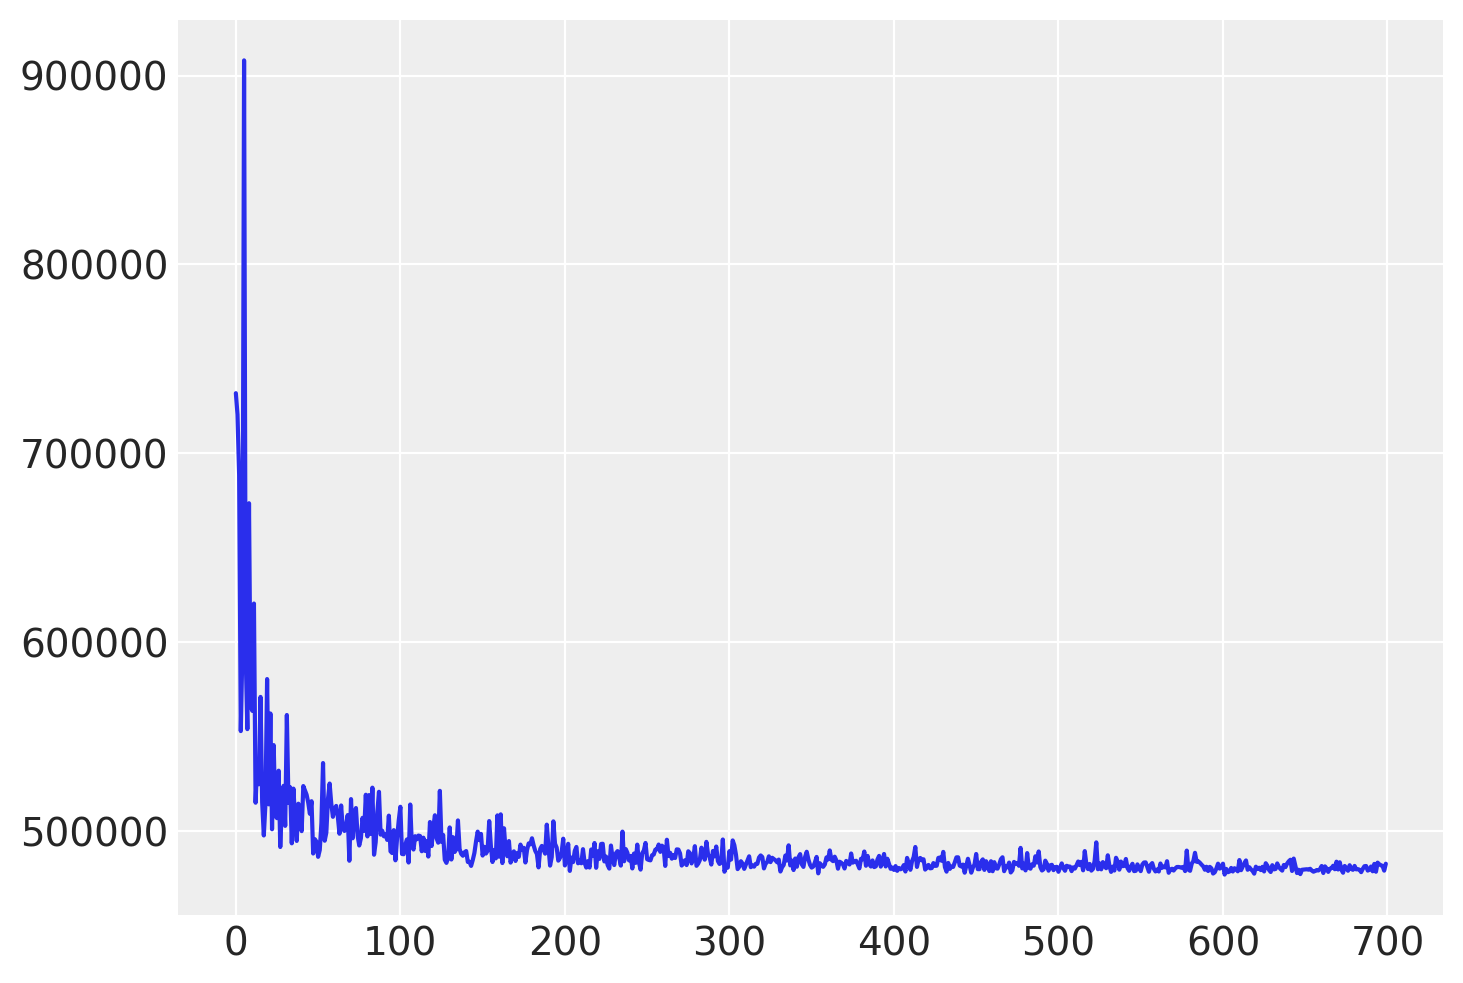

In [126]:
with model2:
    approx2 = pm.fit(method='advi',
                    n=700,
                    obj_n_mc=10,
                    callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute',tolerance=2e-4)],
                    obj_optimizer=pm.adagrad(learning_rate=0.1))
    plt.plot(approx2.hist)

means = approx2.bij.rmap(approx2.mean.eval())
cov = approx2.cov.eval()
sds = approx2.bij.rmap(np.diag(cov)**.5)

In [96]:

help(pm.callbacks.CheckParametersConvergence)

Help on class CheckParametersConvergence in module pymc3.variational.callbacks:

class CheckParametersConvergence(Callback)
 |  CheckParametersConvergence(every=100, tolerance=0.001, diff='relative', ord=inf)
 |  
 |  Convergence stopping check
 |  
 |  Parameters
 |  ----------
 |  every: int
 |      check frequency
 |  tolerance: float
 |      if diff norm < tolerance: break
 |  diff: str
 |      difference type one of {'absolute', 'relative'}
 |  ord: {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
 |      see more info in :func:`numpy.linalg.norm`
 |  
 |  Examples
 |  --------
 |  >>> with model:
 |  ...     approx = pm.fit(
 |  ...         n=10000, callbacks=[
 |  ...             CheckParametersConvergence(
 |  ...                 every=50, diff='absolute',
 |  ...                 tolerance=1e-4)
 |  ...         ]
 |  ...     )
 |  
 |  Method resolution order:
 |      CheckParametersConvergence
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __

/home/markus/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


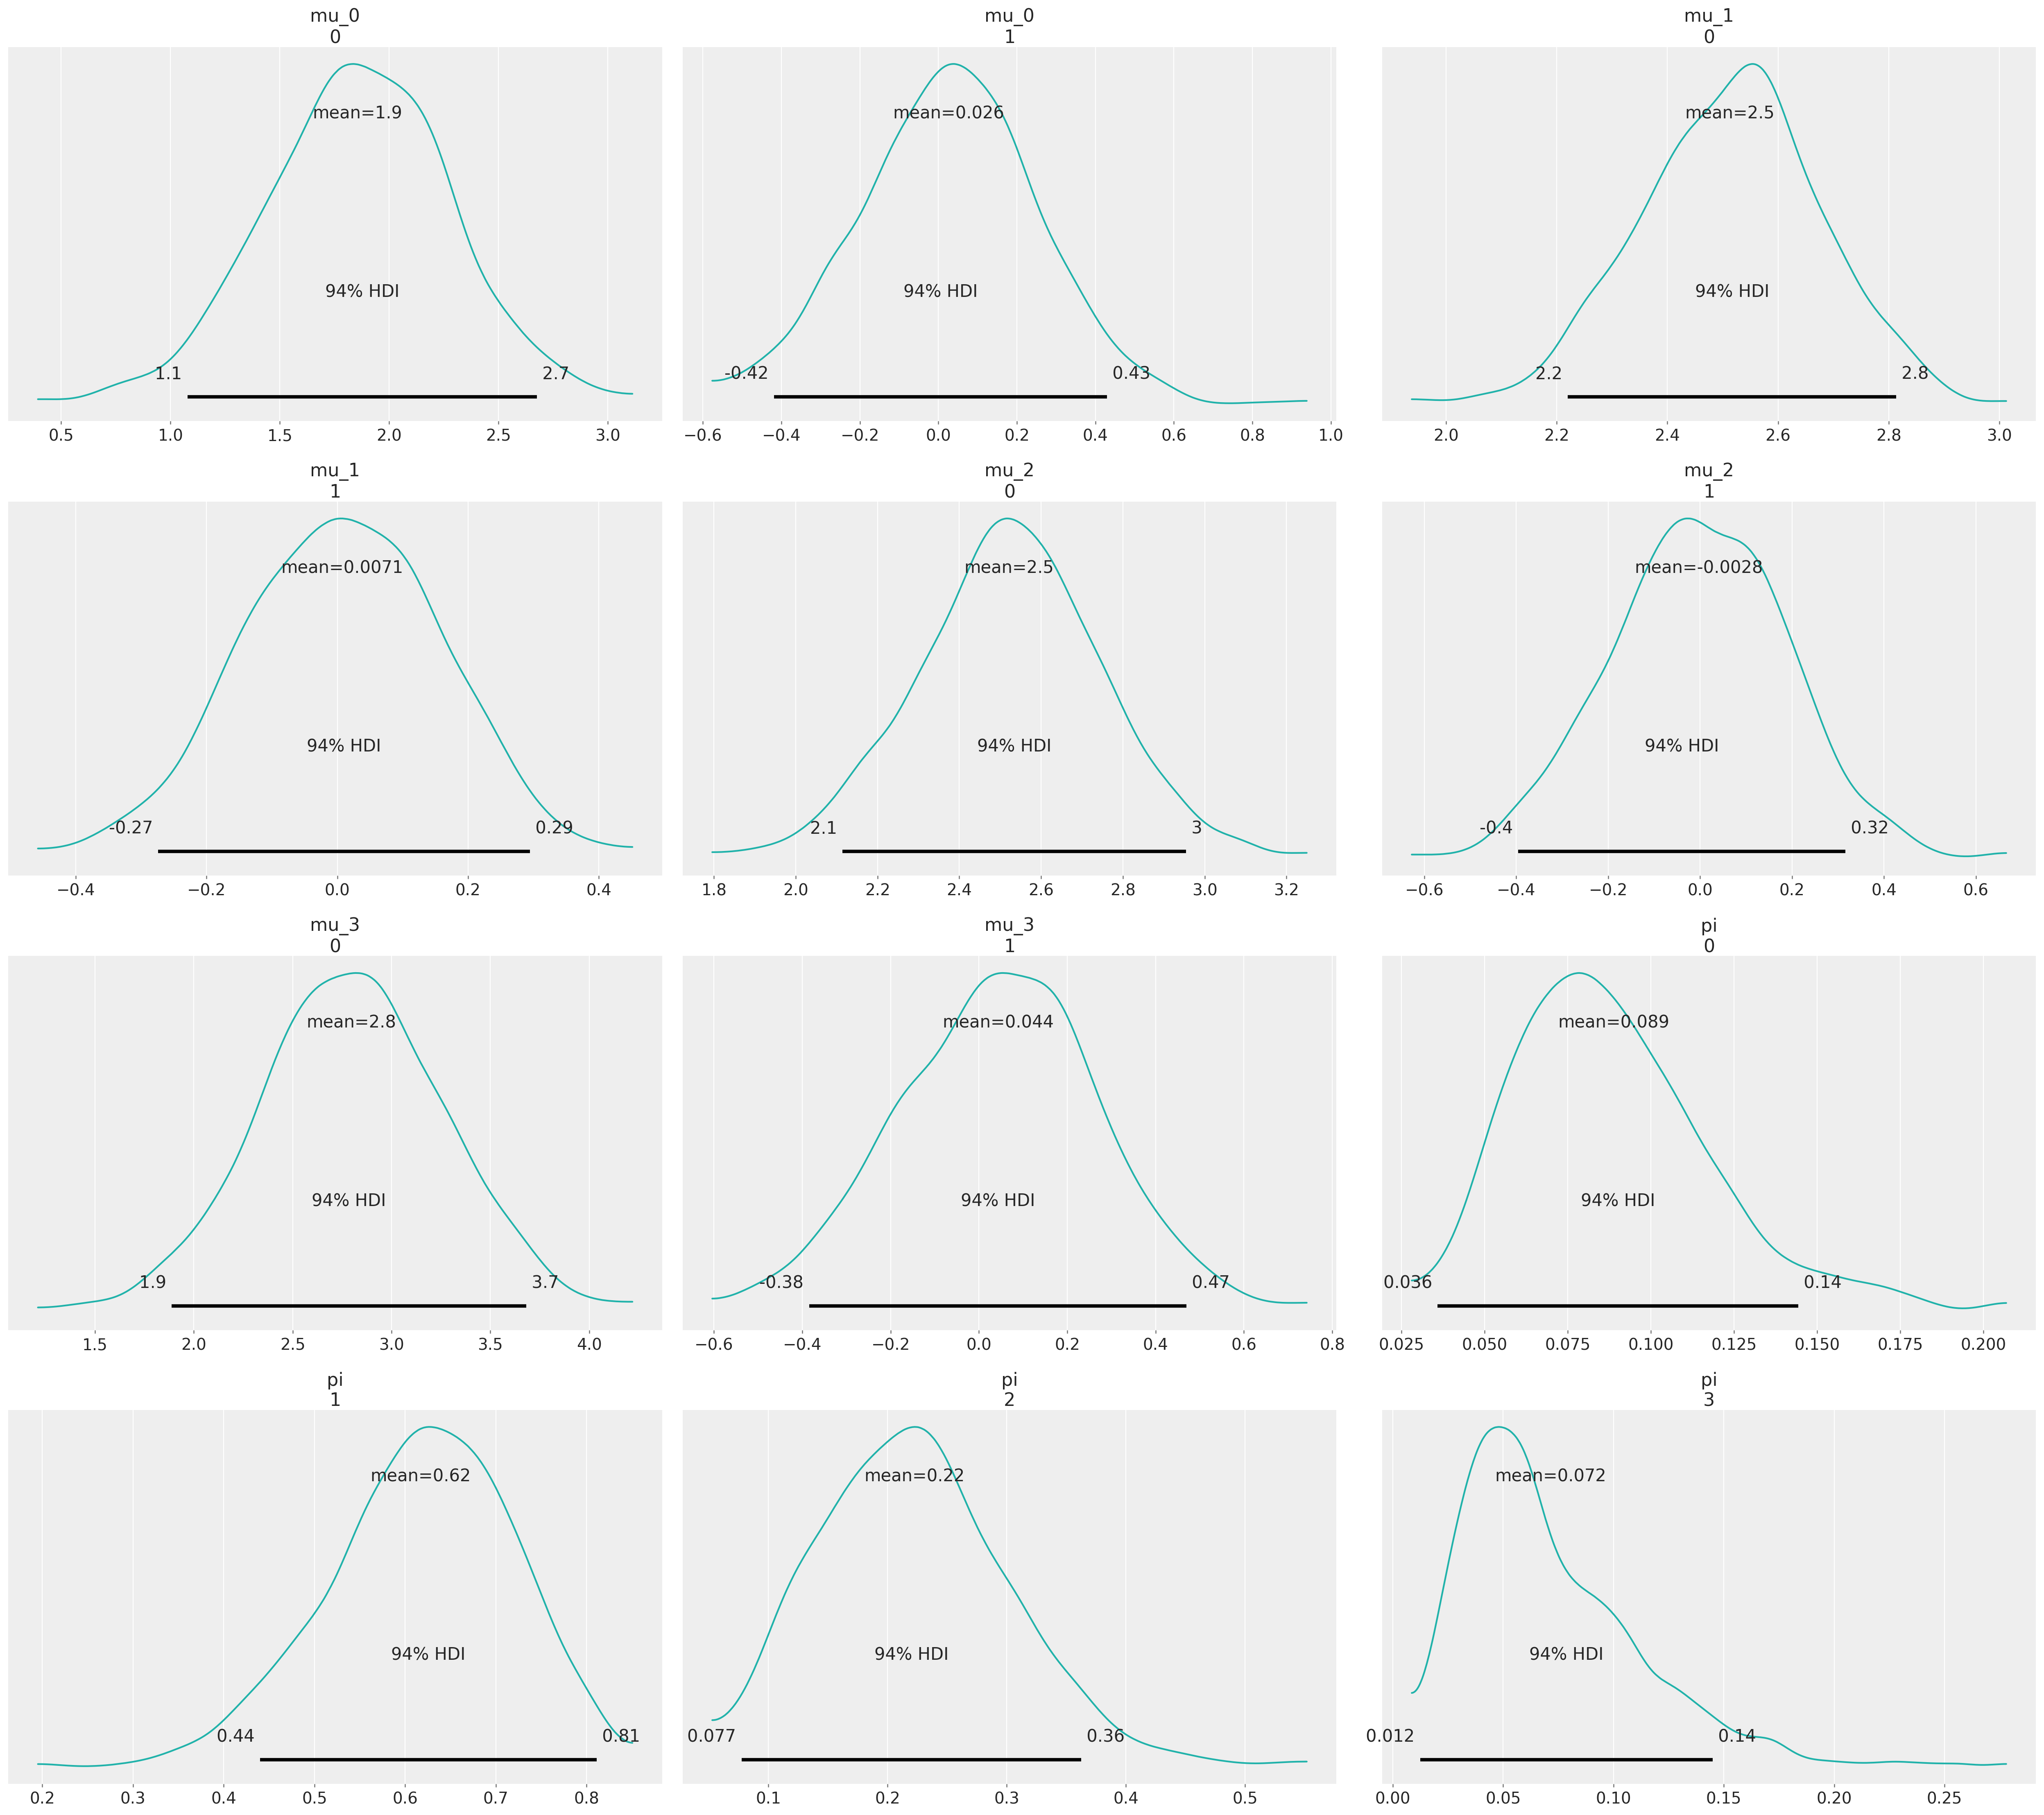

In [70]:
pm.plot_posterior(approx.sample(1000), color='LightSeaGreen');

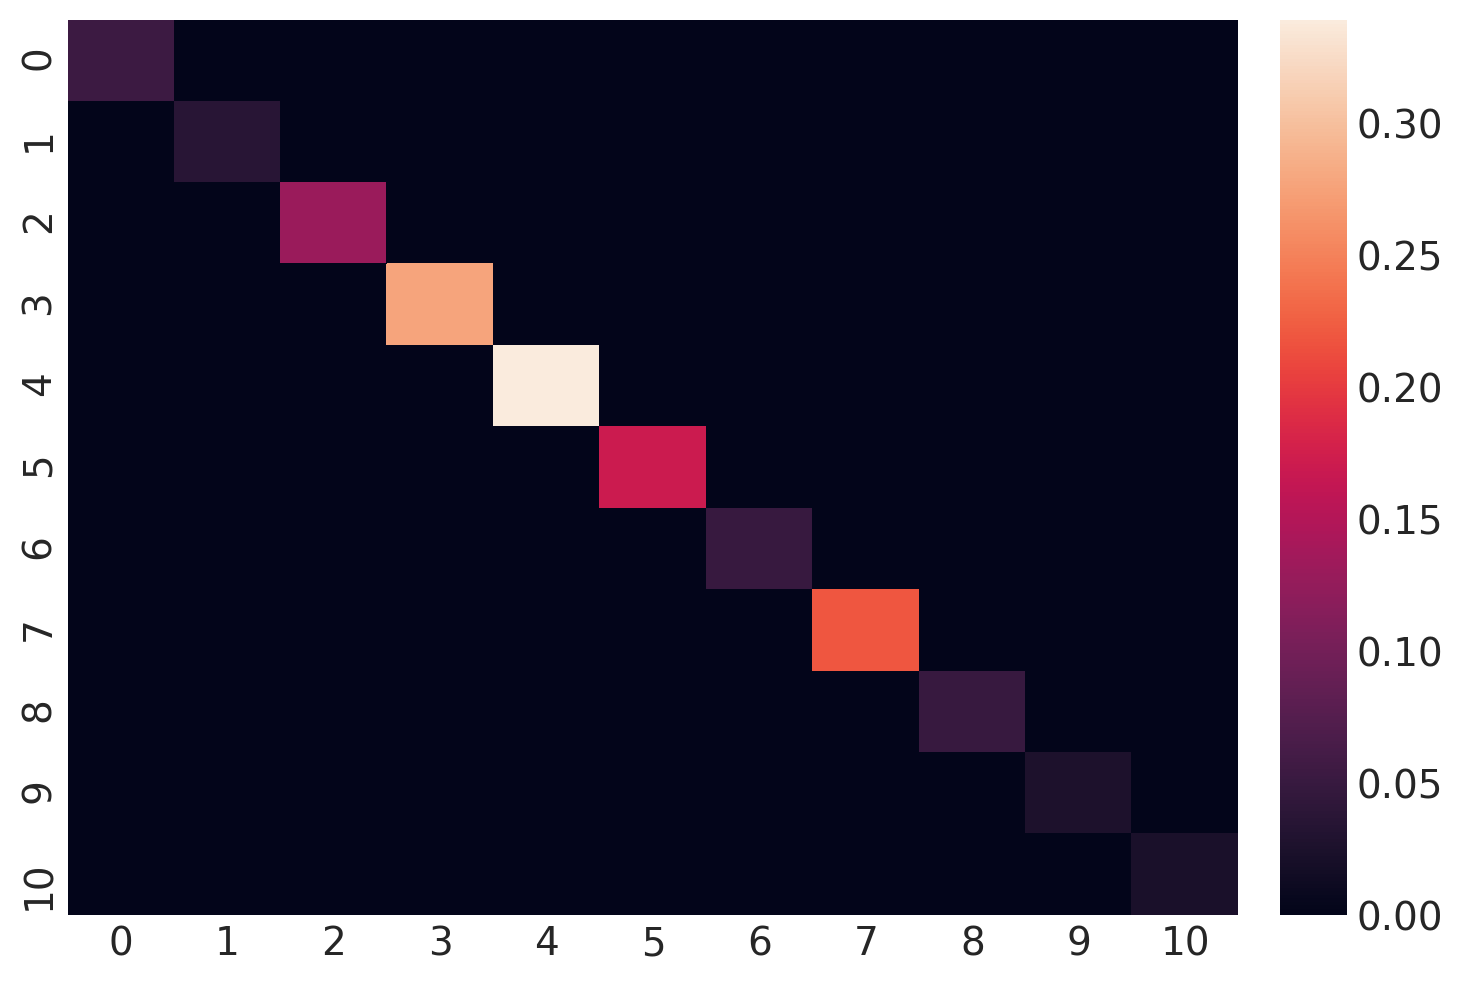

In [71]:
hm = sns.heatmap(cov)

[1.8337586  0.03357477] [0.41258832 0.22292381] 
 [2.50516398 0.01701787] [0.16219821 0.15405741] 
 [ 2.52415482 -0.00532778] [0.23242229 0.19104   ]
[2.50516398 0.01701787] [0.16219821 0.15405741]
[2.50516398 0.01701787] [0.16219821 0.15405741]
[2.50516398 0.01701787] [0.16219821 0.15405741]
[2.50516398 0.01701787] [0.16219821 0.15405741]


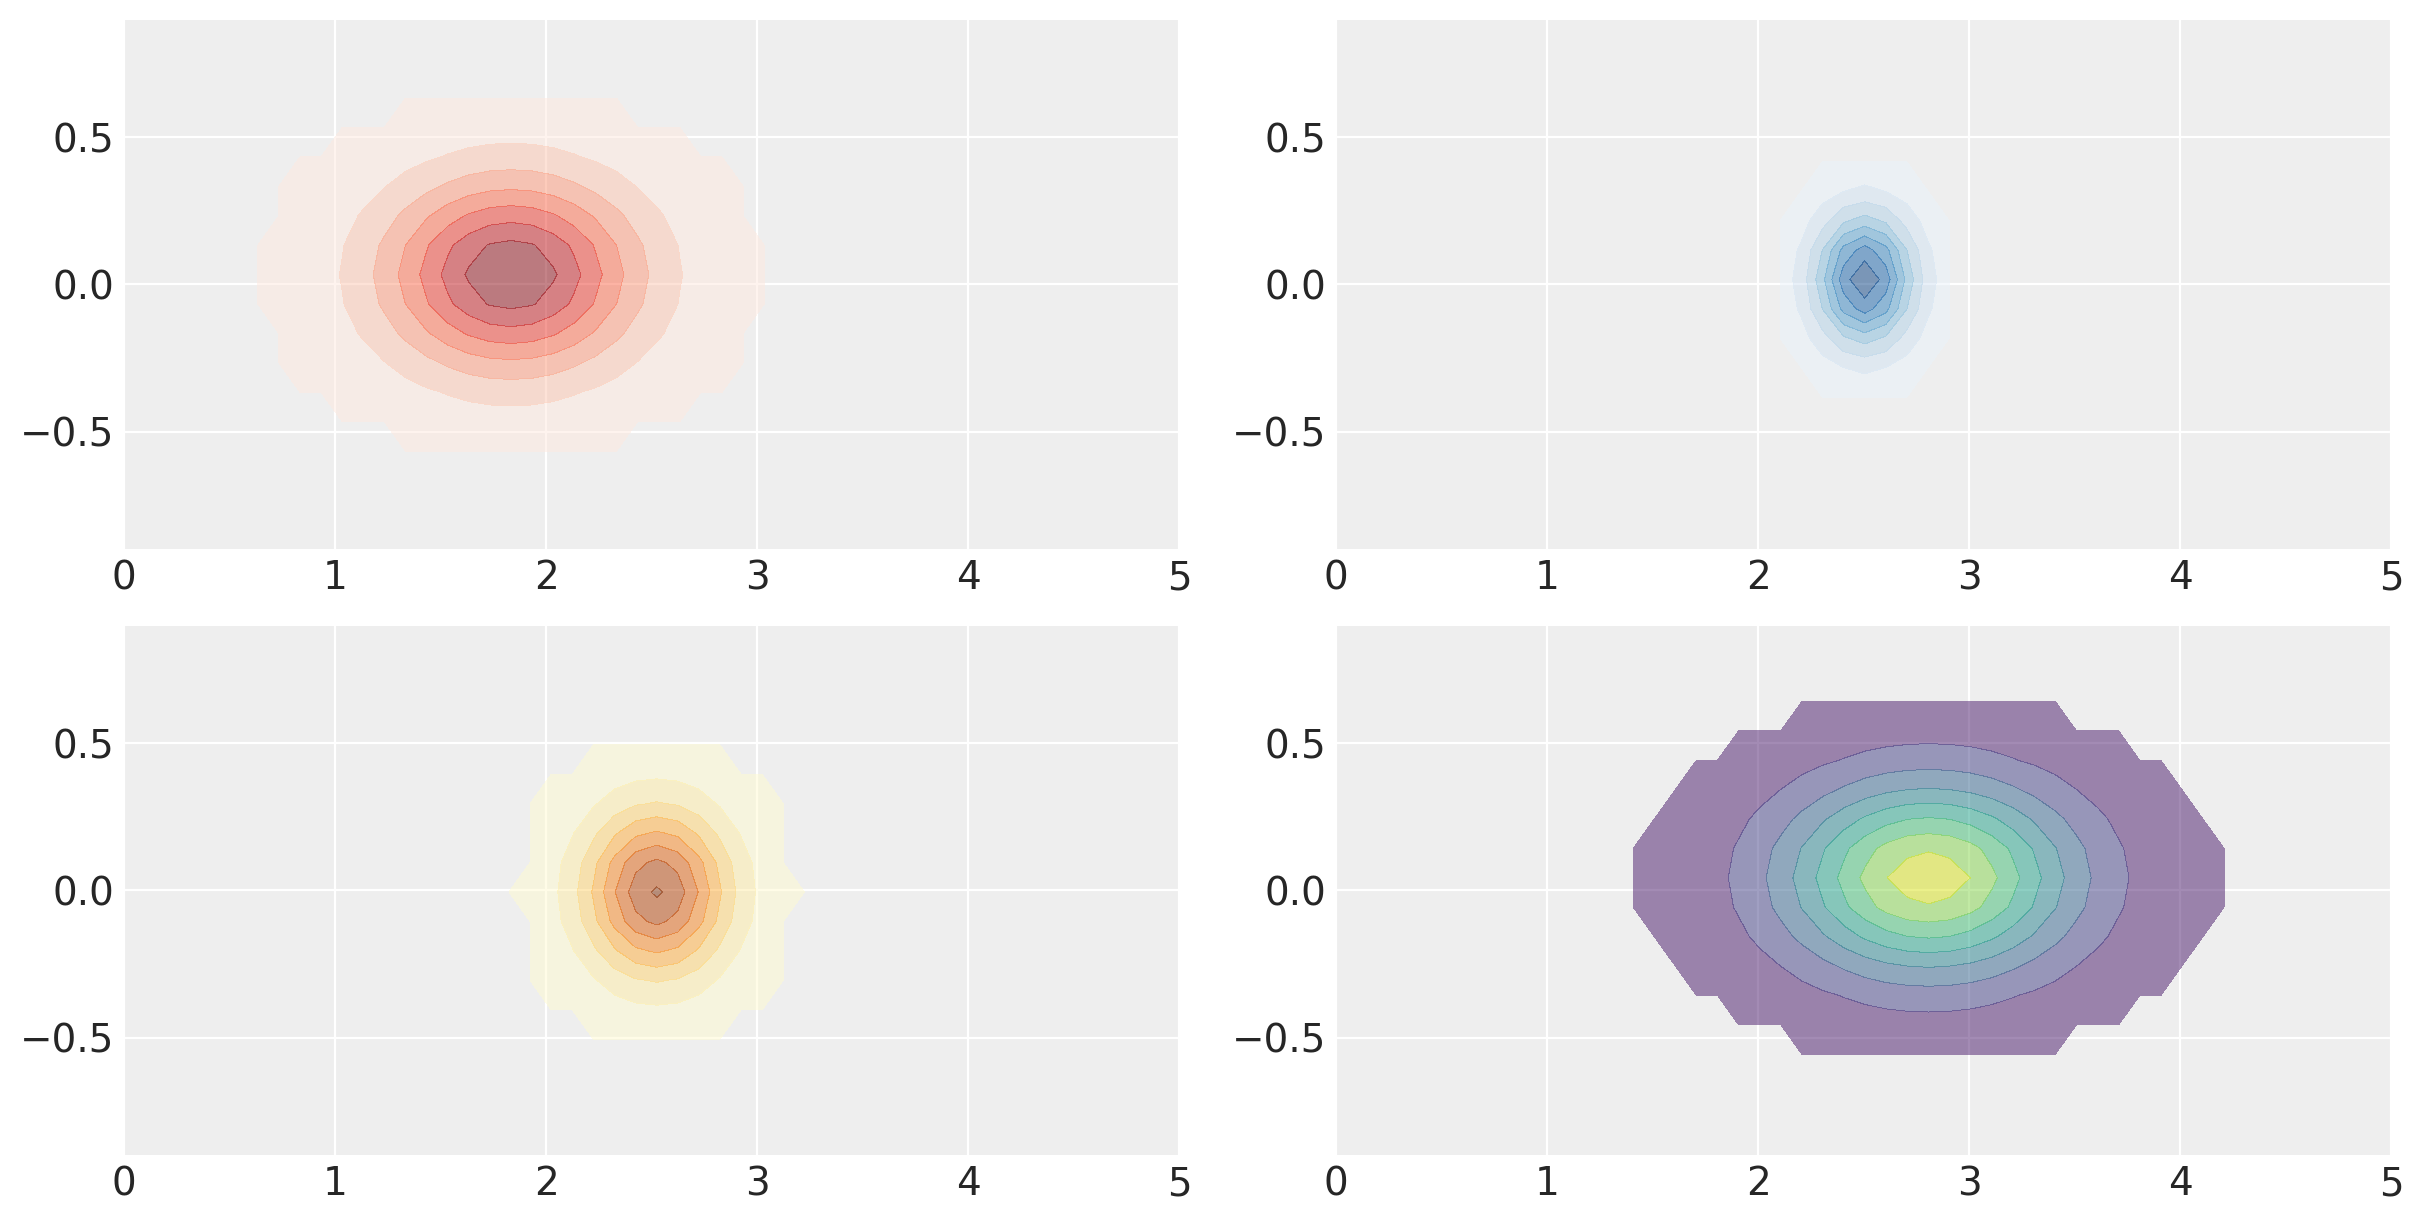

In [81]:
from copy import deepcopy

mu0, sd0 = means['mu_0'], sds['mu_0']
mu1, sd1 = means['mu_1'], sds['mu_1']
mu2, sd2 = means['mu_2'], sds['mu_2']
mu3, sd3 = means['mu_3'], sds['mu_3']

print (mu0, sd0, '\n', mu1, sd1, '\n', mu2, sd2)

def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    print (mu1, sd1)
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    #print(zz)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.5)

fig, ax = plt.subplots(2,2, figsize=(12, 6))
#plt.scatter(xy1[:, 0], xy1[:, 1], alpha=0.5, c='g')
plot_logp_normal(ax[0,0], mu0, sd0, cmap='Reds')
plot_logp_normal(ax[1,0], mu2, sd2, cmap='YlOrBr')
plot_logp_normal(ax[0,1], mu1, sd1, cmap='Blues')
plot_logp_normal(ax[1,1], mu3, sd3, cmap='viridis')
for i in (0,1):
    for j in (0,1):
        ax[i,j].set_xlim(0,5)
        ax[i,j].set_ylim(-0.9,0.9)

#plt.xlim(0, 5)
#plt.ylim(-0.9, 0.9)

### Try a variational autoencoder
and let it guess 

In [ ]:
from pyod.models.vae import VAE
X = df_input['Vx'].values[9500:20000].reshape(-1,1)
XX = np.hstack([X,X])
print (XX.shape)
vaenc = VAE(encoder_neurons=[32, 8, 2], decoder_neurons=[2,8,32],
            latent_dim=2, gamma=1.1, capacity=0.4, verbosity=1)
vaenc.fit(XX)
vae = vaenc.predict_proba(XX)

<ipython-input-243-42c3fd419fb4>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
<ipython-input-243-42c3fd419fb4>:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax[0,1].scatter(x1[m:n], y1[m:n], c=Y[m:n], s=50, edgecolor='', cmap='coolwarm')


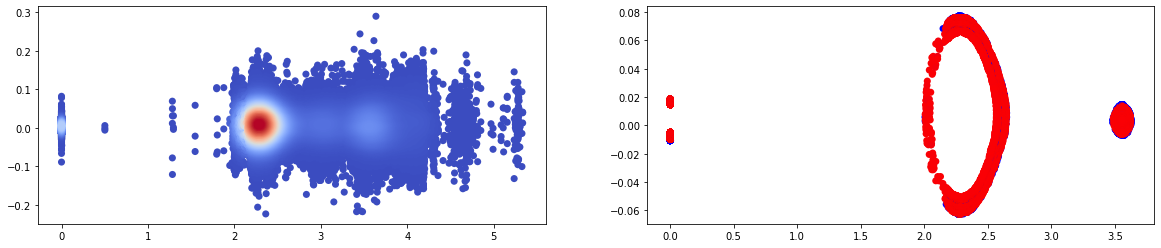

In [243]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4), squeeze=False)
#ax[0,0].scatter(df_1['Ap'], df_1['Vx'], color='green', lw=0.4)
m = 40000
n = 50000
ax[0,0].scatter(x1, y1, c=z1, s=50, edgecolor='', cmap='coolwarm')
ax[0,1].scatter(x1[m:n], y1[m:n], c=Y[m:n], s=50, edgecolor='', cmap='coolwarm')



In [191]:
Y

array([[0.96776935, 0.03223065, 0.        ],
       [0.55216393, 0.44783607, 0.        ],
       [0.146909  , 0.853091  , 0.        ],
       ...,
       [0.98460089, 0.01539911, 0.        ],
       [0.98038921, 0.01961079, 0.        ],
       [0.96617726, 0.03382274, 0.        ]])

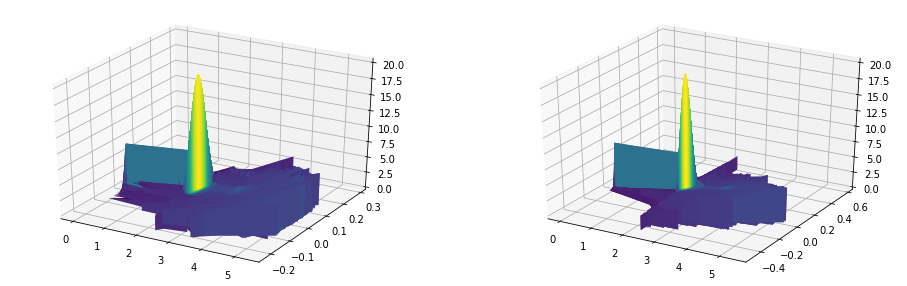

In [169]:
fig2 = plt.figure(figsize=(16, 5))
ax2 = fig2.add_subplot(1,2,1, projection='3d')
ax2.plot_surface(x1, y1, np.vstack([x1,z1]), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax3 = fig2.add_subplot(1,2,2, projection='3d')
ax3.plot_surface(x2, y2, np.vstack([x2,z2]), rstride=1, cstride=1, cmap='viridis', edgecolor='none')


In [193]:
import lightgbm as lgb

params = {"objective": "regression"}

dtrain = lgb.Dataset(df_1[['max','on']][:80000], label=df_1['max'][:80000])
dvalid = lgb.Dataset(df_1[['max','on']][80000:])

model_lgb = lgb.train(params, train_set=dtrain)

predict = model_lgb.predict(df_input[['Vx', 'on']])


In [194]:
predict

array([0.02830253, 0.02830253, 0.02830253, ..., 0.05960131, 0.08010073,
       0.02830253])

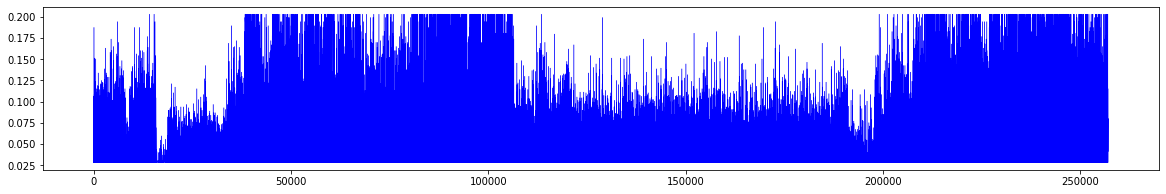

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(20, 3), squeeze=False)
ax[0,0].plot(predict, lw=0.4, color='blue', label='actual')


In [197]:
features = ['max_1']
#features.extend(hour_categories)
#features.extend(weekday_categories)
train_up_to = df_1.shape[0] - 1440
X_train = df_1[:train_up_to][features].T.to_numpy()
X_test = df_1[:train_up_to]['max'].values.reshape(-1, 1).T
Y_train = df_1[train_up_to:][features].T.to_numpy()
Y_test = df_1[train_up_to:]['max'].values.reshape(-1, 1).T

In [198]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, train_up_to, df_1[:train_up_to].shape

((1, 127140), (1, 127140), (1, 1440), (1, 1440), 127140, (127140, 11))

In [199]:
#4,4 have good r2 score for 36 featuers
net = prn.CreateNN([X_train.shape[0],4,4,X_test.shape[0]])

In [200]:
%%time
net = prn.train_LM(X_train,X_test,net,verbose=True,k_max=30,E_stop=1e1)

Iteration:  0 		Error:  69356.56586906931 	scale factor:  3.0
Iteration:  1 		Error:  147.70629465710186 	scale factor:  0.3
Iteration:  2 		Error:  144.78025568135072 	scale factor:  0.3
Iteration:  3 		Error:  144.6774254975471 	scale factor:  3.0
Iteration:  4 		Error:  144.65670185614619 	scale factor:  3.0
Iteration:  5 		Error:  144.6362086236625 	scale factor:  3.0
Iteration:  6 		Error:  144.61519409401112 	scale factor:  3.0
Iteration:  7 		Error:  144.59354504984736 	scale factor:  3.0
Iteration:  8 		Error:  144.5712355100122 	scale factor:  3.0
Iteration:  9 		Error:  144.54825589588148 	scale factor:  3.0
Iteration:  10 		Error:  144.52460043056976 	scale factor:  3.0
Iteration:  11 		Error:  144.50026452055783 	scale factor:  3.0
Iteration:  12 		Error:  144.47524408132412 	scale factor:  3.0
Iteration:  13 		Error:  144.44953524037746 	scale factor:  3.0
Iteration:  14 		Error:  144.42313410399854 	scale factor:  3.0
Iteration:  15 		Error:  144.39603652566598 	scale fac

In [205]:
import math
y = prn.NNOut(X_train,net)
ytest = prn.NNOut(Y_train,net)
print(
f'Training Output error analysis\n\
r2_score: {metrics.r2_score(X_test.T, y)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(X_test.T, y))} \n\
MAE: {metrics.mean_absolute_error(X_test.T, y)}'
)
print()
print(
f'Test Output error analysis\n\
r2_score: {metrics.r2_score(Y_test.T, ytest)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(Y_test.T, ytest))} \n\
MAE: {metrics.mean_absolute_error(Y_test.T, ytest)}'
)


Training Output error analysis
r2_score: 0.12122533764779853 
RMSE: 0.03364248827631957 
MAE: 0.02403449866757209

Test Output error analysis
r2_score: -0.6297136268781758 
RMSE: 0.024759792660032778 
MAE: 0.016865484628109353


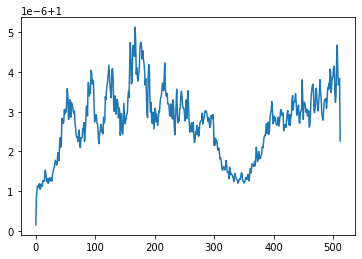

In [57]:
f1, P1xx_den = sp.signal.welch(df_1['Vx'].values, fs=1024, nperseg=1024)
f2, P2xx_den = sp.signal.welch(df_2['Vx'].values, fs=1024, nperseg=1024)
fe1 = np.exp(P1xx_den)
fe2 = np.exp(P1xx_den)
#plt.plot(f1, fe1)
plt.plot(f2, fe2)

In [59]:
sp.fft.fft(df_2['Vx'])

/home/markus/.local/lib/python3.8/site-packages/scipy/fft/_pocketfft/helper.py:97: FutureWarning: Series.flags is deprecated and will be removed in a future version
  copy = not x.flags['ALIGNED']


array([-2616.6371     -0.j        ,   -43.08512705-42.41345218j,
          57.17269729+21.98077182j, ...,   -59.44272061-58.19786469j,
          57.17269729-21.98077182j,   -43.08512705+42.41345218j])

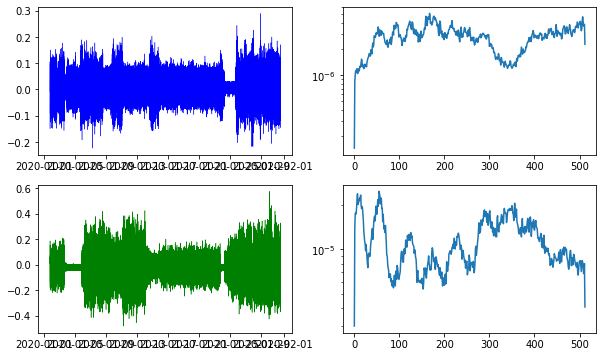

In [157]:
#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(2, 2, figsize=(10, 6), squeeze=False)
ax[0,0].plot(df_1[['Vx']], lw=0.4, color='blue', label='actual')
ax[1,0].plot(df_2[['Vx']], lw=0.5, color='green', label='predicted')
ax[0,1].semilogy(f1, P1xx_den)
ax[1,1].semilogy(f2, P2xx_den)
#ax[0,0].legend()

In [105]:
from pyod.models.vae import VAE
X = df_input['Vx'].values[9500:20000].reshape(-1,1)
XX = np.hstack([X,X])
print (XX.shape)
vaenc = VAE(encoder_neurons=[32, 8, 2], decoder_neurons=[2,8,32],
            latent_dim=2, gamma=1.1, capacity=0.4, verbosity=1)
vaenc.fit(XX)
vae = vaenc.predict_proba(XX)

(10500, 2)


TypeError: __init__() got an unexpected keyword argument 'lr'

In [106]:
#from keras.utils.vis_utils import plot_model
#plot_model(vaenc.model_, show_shapes=True, show_layer_names=True)
vaenc.model_.predict(XX)


array([[0.00975618, 0.00975618],
       [0.00975618, 0.00975618],
       [0.00975618, 0.00975618],
       ...,
       [0.00975618, 0.00975618],
       [0.00975618, 0.00975618],
       [0.00975618, 0.00975618]], dtype=float32)

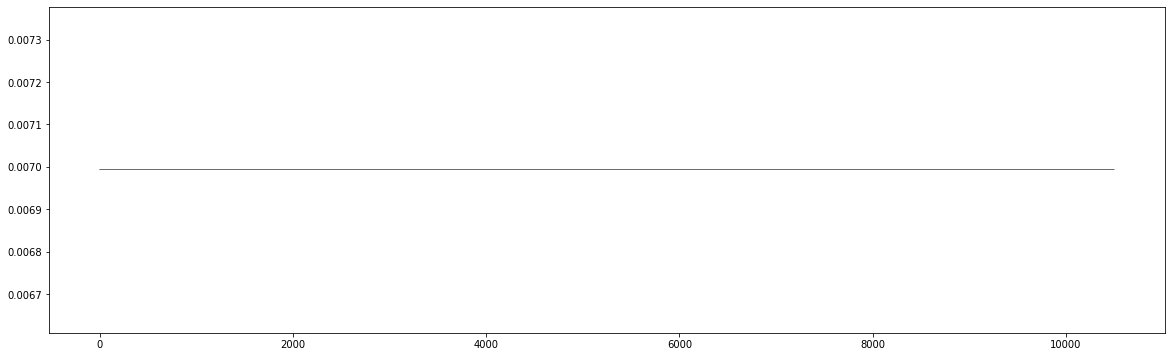

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6), squeeze=False)
ax[0,0].plot(vaenc.model_.predict(XX), lw=0.4, color='blue', label='actual')

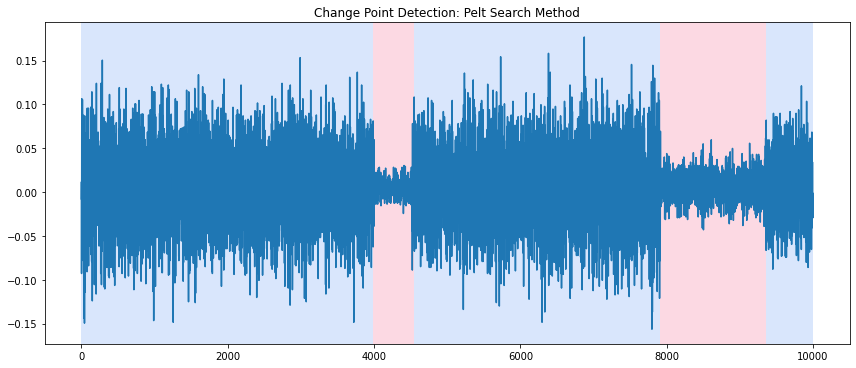

In [80]:
rpt.display(y[0:10000], results, figsize=(12, 5))
plt.title('Change Point Detection: Pelt Search Method')
plt.show() 

### Load data

In [12]:
model.evaluate(X_test, y_test)

39/39 [==============================] - 3s 70ms/step - loss: 0.4712 - mean_squared_error: 0.4712


[0.4711650609970093, 0.4711650609970093]

In [13]:
#model.evaluate(X_train, y_train)
X_train.shape

(6876, 100, 7)

In [14]:
X_train[-24:0].shape

(0, 100, 7)

In [15]:
act = y_train[-2:-1].reshape(-1,1)
pred = model.predict(X_train[-2:-1]).reshape(-1,1)

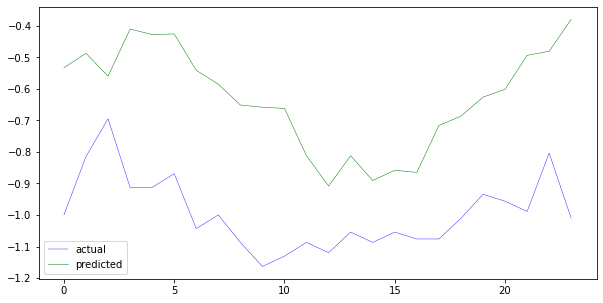

In [16]:
#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
ax[0,0].plot(act, lw=0.4, color='blue', label='actual')
ax[0,0].plot(pred, lw=0.5, color='green', label='predicted')
#ax[1,0].plot(chan.y_hat[6700:], lw=1, color='brown', label='predicted')
ax[0,0].legend()


In [68]:
import torch
import torch.autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.dataset import random_split


def initialize_weights(model):
    print('initialize weights')
    if type(model) in [nn.Linear]:
        nn.init.xavier_uniform_(model.weight.data)
    elif type(model) in [nn.LSTM, nn.RNN, nn.GRU]:
        nn.init.xavier_uniform_(model.weight_hh_l0)
        nn.init.xavier_uniform_(model.weight_ih_l0)

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

class LSTM_2L(nn.Module):
    def __init__(self, n_features = 1, hidden_dims = [80,80], seq_length = 250,
                 batch_size = 64, n_predictions = 10, dropout = 0.1):
        super(LSTM_2L, self).__init__()
        print ('LSTM_2L', n_features, hidden_dims, seq_length, batch_size, n_predictions, dropout)

        self.n_features = n_features
        self.hidden_dim = hidden_dims[0]  # ignore second component for pytorch
        self.seq_length = seq_length
        self.num_layers = len(hidden_dims)
        self.batch_size = batch_size

        # using nn.LSTM so both layers end up with the same number of hidden dimensions
        self.lstm1 = nn.LSTM(
            input_size = self.n_features,
            hidden_size = self.hidden_dim,
            batch_first = True,
            dropout = dropout,
            num_layers = 2)

        self.linear = nn.Linear(self.hidden_dim, n_predictions)
        self.hidden = self.init_hidden_state()

    def init_hidden_state(self):
        #initialize hidden states (h_0, c_0)
        logger.debug('Hidden dimensions are: ' + str(self.num_layers) + ', ' +
                     str(self.batch_size) + ', ' + str(self.hidden_dim))

        return (
            Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_dim)), #.to(self.device),
            Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_dim)) #.to(self.device),
            )

    def forward(self, sequences, hidden = None):

        try:
            batch_size, seq_len, n_features = sequences.size()  # batch first
            logger.debug ('forward| Batch size: ' + str(batch_size) + ' Sequence length: ' + 
                          str(seq_len) + 'Output length:' + str(n_features))
        except Exception:
            logger.info ('forward issue in sequence: ' + str(sequences))

        #  for training
        if hidden is not None:
            self.hidden = hidden

        lstm1_out, hidden_out = self.lstm1(sequences, hidden)

        last_time_step = lstm1_out[:,-1,:]    # from (batch.size, input.size, hidden_dim.size)

        #lstm1_out_reshaped = lstm1_out.reshape(tuple((-1, *lstm1_out.shape[2:])))
        logger.debug ('Shapes ' + str(lstm1_out.shape) + ', ' + str(last_time_step.shape)
                      + ', ' + str(last_time_step.shape))

        #last_time_step = lstm1_out.view(-1, self.hidden_dims[0])

        #y_pred = self.linear(lstm1_out_reshaped)
        y_pred = self.linear(last_time_step)

        return y_pred, hidden_out


### Tensorboard support

Run `tensorboard --log=.\` in the notebooks directory to pick up training results

In [69]:
#instantiate summary writer
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# instantiate LSTM with input shape from training data
lstm = LSTM_2L(n_features = X_train.shape[2], hidden_dims = (80,80),
                 seq_length = 100, batch_size = 64,
                 n_predictions = 24, dropout = 0.1)

loss_function = nn.MSELoss()

# lr 0.0005 is a bit low, same with 0.0009, 0.0012, 0.0019
#    0.0029 looks better (test loss is lower, too)
#    0.0039 is too high (sharp spike in epoch 37)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0034)  

epochs = 45
train_hist = np.zeros(epochs)

# split out validation bucket
X_train_, X_validation_, y_train_, y_validation_ = train_test_split(X_train, y_train, train_size=0.8)

train_dataset=TensorDataset(torch.Tensor(X_train_),torch.Tensor(y_train_))
validation_dataset=TensorDataset(torch.Tensor(X_validation_),torch.Tensor(y_validation_))

train_loader = DataLoader(dataset=train_dataset, batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=64, drop_last=True, shuffle=True)


lstm.train()

print("Beginning model training...")

validation_losses = []

hidden = lstm.init_hidden_state()
for t in range(epochs):
    train_losses_batch = []
    print ('Epoch ', t)

    i = 0
    for X_batch_train, y_batch_train in train_loader:
        #print ('Batch ', i)

        #self.model.zero_grad()

        i += 1

        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_train, hidden = lstm(X_batch_train, hidden=hidden)

        loss = loss_function(y_hat_train.float(), y_batch_train)
        train_loss_batch = loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        logger.debug('Batch ' + str(i-1) + ', Training loss ' + str(train_loss_batch))
        train_losses_batch.append(train_loss_batch)

    training_loss = np.mean(train_losses_batch)
    logger.debug ('After batch ' + str(i-1) + ', average training loss: ' + str(training_loss))
    
    writer.add_scalar('Loss/train', training_loss, t)
    train_losses_batch.append(training_loss)
    
    with torch.no_grad():
        val_losses_batch = []
        j = 0
        for X_val_batch, y_val_batch in val_loader:
            lstm.eval()
            y_hat_val, _ = lstm(X_val_batch, hidden=hidden)
            val_loss_batch = loss_function(y_hat_val.float(), y_val_batch).item()
            logger.debug('Validating batch ' + str(j) + ', validation loss: ' + str(val_loss_batch))
            val_losses_batch.append(val_loss_batch)
        validation_loss = np.mean(val_losses_batch)
        print('After batch ' + str(i-1) + ', average validation loss: ' + str(validation_loss))
        
        writer.add_scalar('Loss/validation', validation_loss, t)
        validation_losses.append(validation_loss)

    print(f"[{t+1}] Training loss: {training_loss} \t Validation loss: {validation_loss} ")
    if training_loss < 0.02 and validation_loss < 0.02:
        break

print('Training complete...')

# return the model after switching off training mode
lstm.eval()


#history = model.fit(X_train, y_train, batch_size=64, epochs=27, validation_split=0.2, 
#                    shuffle=True, callbacks=cbs, verbose=True)

LSTM_2L 10 (80, 80) 100 64 24 0.1
Beginning model training...
Epoch  0
After batch 84, average validation loss: 0.38793562991278513
[1] Training loss: 0.528482494985356 	 Validation loss: 0.38793562991278513 
Epoch  1
After batch 84, average validation loss: 0.33515115011306035
[2] Training loss: 0.3398441800299813 	 Validation loss: 0.33515115011306035 
Epoch  2
After batch 84, average validation loss: 0.3162312642449424
[3] Training loss: 0.3000164931311327 	 Validation loss: 0.3162312642449424 
Epoch  3
After batch 84, average validation loss: 0.2719405988852183
[4] Training loss: 0.2800734283292995 	 Validation loss: 0.2719405988852183 
Epoch  4
After batch 84, average validation loss: 0.25463778773943585
[5] Training loss: 0.25003153190893285 	 Validation loss: 0.25463778773943585 
Epoch  5
After batch 84, average validation loss: 0.21877374748388925
[6] Training loss: 0.22282580908607033 	 Validation loss: 0.21877374748388925 
Epoch  6
After batch 84, average validation loss: 0.2

LSTM_2L(
  (lstm1): LSTM(10, 80, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=80, out_features=24, bias=True)
)

In [70]:
torch.save(lstm.state_dict(), './mylstmintorch')
# get all parameters with values
#  all_my_parameters = list(lstm.lstm1.named_parameters())

In [71]:
# validate on the test set
test_dataset=TensorDataset(torch.Tensor(X_test),torch.Tensor(y_test))

test_loader = DataLoader(dataset=test_dataset, batch_size=64, drop_last=True)

i = 0
loss_test_batch = []
for X_batch_test, y_batch_test in test_loader:
    #print ('Batch ', i)

    i += 1
    
    with torch.no_grad():
        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_test, hidden = lstm(X_batch_test, hidden=hidden)

        loss_test_batch.append(loss_function(y_hat_test.float(), y_batch_test).item())

    
loss_test = np.mean(loss_test_batch)
    
print('Loss Test ', loss_test)


fulltrain_dataset=TensorDataset(torch.Tensor(X_train),torch.Tensor(y_train))
fulltrain_loader = DataLoader(dataset=train_dataset, batch_size=64, drop_last=True)

i = 0

loss_tr_batch = []
for X_batch_tr, y_batch_tr in fulltrain_loader:
    #print ('Batch ', i)

    i += 1
    
    with torch.no_grad():
        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_tr, hidden = lstm(X_batch_tr, hidden=hidden)

        loss_tr_batch.append(loss_function(y_hat_tr.float(), y_batch_tr).item())
        prediction=y_hat_tr.float().numpy()
  
loss_tr = np.mean(loss_tr_batch)
    
print('Loss Train ', loss_tr)

    

Loss Test  0.39364978009344714
Loss Train  0.03463609759860179


In [72]:
prediction[-1]

array([-0.8395002 , -0.78541046, -0.774733  , -0.77409226, -0.80961925,
       -0.8505587 , -0.8513826 , -0.81975955, -0.77553904, -0.7984239 ,
       -0.7271275 , -0.67241806, -0.7251042 , -0.7545871 , -0.7072294 ,
       -0.64929605, -0.6648128 , -0.7086412 , -0.68326515, -0.63684744,
       -0.59898293, -0.618932  , -0.6487712 , -0.66742826], dtype=float32)

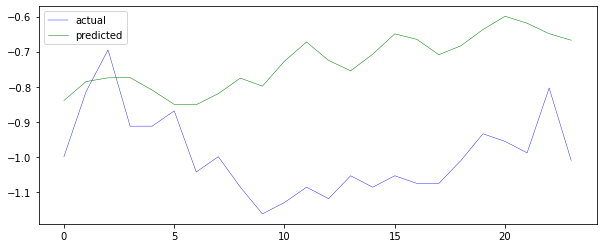

In [80]:
act = y_train[-2:-1].reshape(-1,1)
pred = prediction[-1]

#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(1, 1, figsize=(10, 4), squeeze=False)
ax[0,0].plot(act, lw=0.4, color='blue', label='actual')
ax[0,0].plot(pred, lw=0.5, color='green', label='predicted')
#ax[1,0].plot(chan.y_hat[6700:], lw=1, color='brown', label='predicted')
ax[0,0].legend()

#### Training parameters

```
loss_metric: 'mse'    # minimize mean square error
optimizer: 'adam'     # sort of adaptive stochastic gradient descent
validation_split: 0.2 # 20% of the data is used for validating (val_loss)
dropout: 0.3          # ditch 30% of the LSTMs results when minimizing the loss function to avoid overfitting
lstm_batch_size: 64   # number of training data batches to evaluate per optimizer run to update the model’s parameters

patience: 10          # try at least 10 times to decrease val_loss smaller by ...
min_delta: 0.0003     # ... at least min_delta, else stop, so we get at least 'patience' epochs
epochs: 35            # no more than 35 passes through the entier training dataset.

l_s: 250              # lookback: num previous timesteps provided to model to predict future values
n_predictions: 10     # number of steps ahead to predict
```

This is defined in `telemanom/config.yaml`
<br>